# Data extraction and calculation of constants used for model

In [1]:
%matplotlib widget
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from IPython.display import clear_output
from numpy.linalg import eigh
from numpy.linalg import eig
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

## Fitting data

This part determines the experimental constants that will be employed in the polariton model

### Fetching data, defining absorptions, finding peaks and valleys

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
font_size = 20

# Fetching data
data      = np.loadtxt('Data/AbsCoefficient_Data.txt', delimiter=',')
energy    = data[:, 0]
spectrum  = data[:, 1]
spectrum -= 100  # Correction for Fresnel Coeff.

# Fano absorption profile [LORENTZIAN] 
def Fano(E, Q, scaler, translation, E_n, lineWidth):
    delta_N = (E-E_n*translation)
    return scaler*(lineWidth/2+2*Q*delta_N)/((lineWidth/2)**2+delta_N**2)

# Phonon absorption profile [√X]
def Phonon(E, c, h, E_n):
    diff = E-E_n
    diff[diff < 0] = 0
    output = c*np.sqrt(diff)
    return output+h

# Flipping the data so it goes left to right
energyR = np.flip(energy)
spectrumR = np.flip(spectrum)

# Finding peaks
peaks, props = find_peaks(spectrumR, 400)
peaks = peaks[:-1] # Index of each peak

# Finding valleys
valleys = []
for i in range(len(peaks)):
    valleys.append(list(spectrumR).index(np.min(spectrumR[peaks[i]:])))

### Curve fitting to data

The first cell does not converge even with lage runtimes, the second cell uses the best guess from the last run of the first cell to plot a curve fit to the data

The maximum number of guesses is set so that this code will not run.

In [3]:
from IPython.display import clear_output
masterFit2 =  []

# Master fitting function fitting sum of fano peaks and phonon backgrounds

# E    - the the independent variable

# E_bs - array of the staring energies of all the phonon backgrounds
# Cs   - array of scaling factors associated with each phonon backgrounds
# h0   - the shared offset of all the phonon backgrounds

# E_ns - array of all the peak energies of the fano absorption profiles
# Qs   - array of Q factors (assymtry) associated with each fano peak
# Ss   - array of scaling factors associated with each fano peak
# Ts   - array of translation factors associated with each fano peak
# Γs   - array of linewidhts associated with each fano peak

def Master(E, E_ns, E_bs, Qs, Ss, Ts, Γs, Cs, h0):
    
    # Generating and printing temp varialbe to keep track of last attempt by the curve fit
    masterFit2 = [*Qs, *Ss, *Ts, *Γs, *Cs, h0]
    clear_output(wait=True)
    print(masterFit2)

    # Initializing and adding fano peaks to absorption spectra
    sumPeaks = np.zeros(len(E))
    for i in range(len(E_ns)): # Per fano peak energy
        E_n = E_ns[i]
        Q = Qs[i]
        Γ = Γs[i]
        s = Ss[i]
        t = Ts[i]
        sumPeaks += Fano(E, Q, s, t, E_n, Γ)

    # Initializing and adding phonon backgrounds to absorption spectra
    for i in range(len(E_bs)): # Per phonon starting energy
        E_b = E_bs[i]
        c = Cs[i]
        sumPeaks += Phonon(E, c, h0, E_b)
    return sumPeaks

# Upper and lower bounds for the curve_fit
b = ([np.NINF]*48, [np.inf]*48)
b[0][-4:-1] = [0,0,0]

# Initial guess from earlier calculations
guess = [-0.46325779435939973, -0.30924789244990397, -0.2924886260356818, -0.2513848066354517, -0.28427149303411503, -0.27103746873164386, -0.12478135049741794, 0.2577495365047902, 3.087439313810274, -2.340063442077149, -0.6236933574709753, 0.30181007743679933, 0.13772266237725564, 0.07393931556212606, 0.03791919952963015, 0.02314034069436723, 0.015829904293650547, 0.013207345074723636, 0.008028154492379732, 0.0004911078975545184, 0.0775989996613211, 0.17842937233032907, 1.0002316889115006, 1.000044693671246, 1.000014149809435, 1.0000169311710378, 1.0000104381148707, 1.000010973453564, 1.000004584010458, 0.9999878321011558, 0.9999679124022053, 1.0009143793752113, 0.9977057520657785, 0.002844077894710434, 0.0007259020720680305, 0.00035994544263489415, 0.00023176542392245298, 0.00019543722015703756, 0.000180122512070042, 0.00018098442666410967, 0.00017593016698887483, 0.00012956014528625384, -8.726018703609294e-05, 0.006709046095180002, 0.49572166849964566, 585.6870248217446, 1860.1704273562152, 47.30954131922511]

masterFit, masterCov = curve_fit((lambda x, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, Q11, Q12,
                                  S2, S3, S4, S5, S6, S7, S8, S9, S10, S11, S12,
                                  T2, T3, T4, T5, T6, T7, T8, T9, T10, T11, T12,
                                  Γ2, Γ3, Γ4, Γ5, Γ6, Γ7, Γ8, Γ9, Γ10, Γ11, Γ12,
                                  C1, C2, C3, h0: Master(x, energyR[peaks], 
                                                            [2.115, energyR[valleys[0]], energyR[valleys[2]]],
                                                            [Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, Q11, Q12], 
                                                            [S2, S3, S4, S5, S6, S7, S8, S9, S10, S11, S12],
                                                            [T2, T3, T4, T5, T6, T7, T8, T9, T10, T11, T12],
                                                            [Γ2, Γ3, Γ4, Γ5, Γ6, Γ7, Γ8, Γ9, Γ10, Γ11, Γ12], 
                                                            [C1, C2, C3], h0)),
                                  energyR[:-567], spectrumR[:-567], maxfev = 2, 
                                 p0 = guess, bounds=b)

fig,ax = plt.subplots(figsize=(10, 6))
plt.plot(energyR[:-553], spectrumR[:-553])
plt.plot(energyR[:-553], Master(energyR[:-553], energyR[peaks], [2.115, energyR[peaks[0]], energyR[peaks[2]]],
                               masterFit[0:11], masterFit[11:22], masterFit[22:33], masterFit[33:44], masterFit[44:47], masterFit[47]))

[-0.4602108099072475, -0.3090383770460319, -0.2907478846742393, -0.2530428441926484, -0.28390416070735747, -0.26393727663016736, -0.11316044860441009, 0.2904903118287361, 5.375849555249584, -1.5364850394879301, -0.7865144362806746, 0.2980182283810939, 0.13738822707733786, 0.07322346832885179, 0.037899139158043174, 0.023038118626922895, 0.015913390043741572, 0.013599859246785768, 0.00841260968436073, 0.00017320478319921207, 0.18326502006548706, 0.13469669989853017, 1.0002321844122861, 1.0000446449094689, 1.0000141584126296, 1.0000170433648776, 1.0000104140511743, 1.0000106722493982, 1.0000041601838419, 0.9999869298295819, 0.9999656242075053, 1.0046075668217112, 0.9977906271763376, 0.0028267208918199395, 0.0007244412467394127, 0.00035838317592616495, 0.00023191064058767003, 0.00019474837138496864, 0.00018013347031083524, 0.0001836920769511522, 0.00018344236388799514, 0.00013345054117806288, 0.049497434071917874, 0.006672467290673638, 26.406158397406955, 509.87752981311775, 1619.254928744

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

[-0.3515811046388097, -0.3030814280028518, -0.22436952199744337, -0.24773032726049987, -0.30388293542970435, -0.27718488459975515, -0.09374203076966336, 0.339189622788944, 3.122769021037774, -2.3427904405614535, -1.0693242769638183, 0.32734474884886183, 0.13923599131687941, 0.07281172077057994, 0.038825190568024276, 0.022623313495228295, 0.014965296080919756, 0.012031885695466881, 0.006003761921925143, 0.00039033199394252697, 0.14033557415832337, 0.0860150992205259, 1.0001964289579262, 1.0000435385958142, 1.0000094280036542, 1.0000166923984584, 1.0000114303229657, 1.0000111535946636, 1.0000028766946911, 0.9999848219201372, 0.9999693399112902, 1.0014519985047585, 0.9978739483300691, 0.0029296033247892105, 0.0007293884820310447, 0.00035488019235617235, 0.00023546746417424226, 0.0001946539901177581, 0.00017403800075271568, 0.00017087203168998755, 0.0001562708300445982, 0.00011673837877347739, 1.5922160537134992e-05, 0.004643431277388973, 0.49887903781411147, 573.6693657556287, 1855.111293

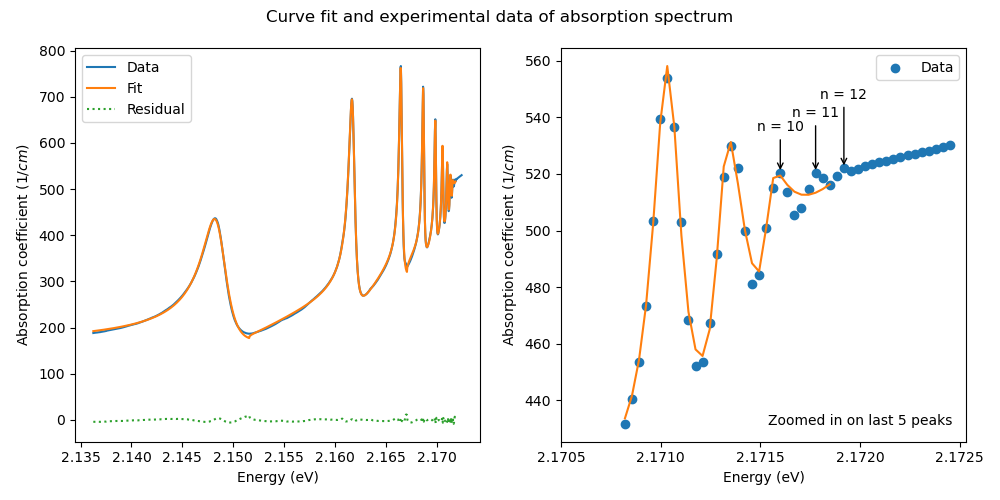

In [4]:
# Previous best guess:
masterFit2 = [[-0.3515811046388097, # Q
             -0.3030814280028518, 
             -0.22436952199744337, 
             -0.24773032726049987, 
             -0.30388293542970435, 
             -0.27718488459975515, 
             -0.09374203076966336, 
             0.339189622788944, 
             3.122769021037774, 
             -2.3427904405614535, 
             -1.0693242769638183],
             
             [0.32734474884886183, # S
             0.13923599131687941, 
             0.07281172077057994, 
             0.038825190568024276, 
             0.022623313495228295, 
             0.014965296080919756, 
             0.012031885695466881, 
             0.006003761921925143, 
             0.00039033199394252697,
             0.14033557415832337, 
             0.0860150992205259],
             
             [1.0001964289579262,  # Translation
             1.0000435385958142, 
             1.0000094280036542, 
             1.0000166923984584, 
             1.0000114303229657, 
             1.0000111535946636, 
             1.0000028766946911, 
             0.9999848219201372, 
             0.9999693399112902, 
             1.0014519985047585, 
             0.9978739483300691], 
             
             [0.0029296033247892105, #Linewidth
             0.0007293884820310447, 
             0.00035488019235617235, 
             0.00023546746417424226, 
             0.0001946539901177581, 
             0.00017403800075271568, 
             0.00017087203168998755, 
             0.0001562708300445982, 
             0.00011673837877347739, 
             1.5922160537134992e-05, 
             0.004643431277388973],
             
             [0.49887903781411147, # Phonon scaling
             573.6693657556287, 
             1855.11129387099], 
             
             [47.15129292494508]]

# Plotting the data and the fit:
end = 570
fig,ax = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle("Curve fit and experimental data of absorption spectrum")
ax[0].plot(energyR[:-553], spectrumR[:-553], label="Data")
ax[0].plot(energyR[:-end], Master(energyR[:-end], energyR[peaks], [0, energyR[valleys[0]], energyR[valleys[2]]],
                               *masterFit2), label="Fit")
ax[0].plot(energyR[:-end], spectrumR[:-end] - Master(energyR[:-end], energyR[peaks], [0, energyR[valleys[0]], energyR[valleys[2]]],
                               *masterFit2), label="Residual", linestyle =":")
start = 1000
ax[1].scatter(energyR[start:-553], spectrumR[start:-553], label="Data")
ax[1].plot(energyR[start:-end], Master(energyR[start:-end], energyR[peaks], [0, energyR[valleys[0]], energyR[valleys[2]]],
                               *masterFit2), color="tab:orange")
ax[1].annotate('Zoomed in on last 5 peaks', xy=(1, 0), xycoords='axes fraction', xytext=(-10, 10), textcoords='offset points', ha='right', va='bottom')

# Annotate peaks
xy = [(0, 30), (0, 40), (0, 50)]

for i, peak_idx in enumerate(peaks[-3:]):
    plt.annotate(f'n = {i + 10}', (energyR[peak_idx], spectrumR[peak_idx]), textcoords="offset points", xytext=xy[i], ha='center', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    #plt.annotate(f'n = {i + 10}', (energyR[peak_idx], spectrumR[peak_idx]), textcoords="offset points", xytext=(0,5+(i*8)), ha='center')


ax[0].set_xlabel("Energy (eV)")
ax[0].set_ylabel("Absorption coefficient ($1/cm$)")
ax[1].set_xlabel("Energy (eV)")
ax[1].set_ylabel("Absorption coefficient ($1/cm$)")
ax[1].set_xticks(ax[1].get_xticks()[::2])

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0)




### Fitting the last 3 peaks

The last 3 peaks need to be fitted by themselves since the curve fit does not converge for them

/tmp/ipykernel_270/1569709325.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, cov = curve_fit(lambda x, Q, s, t, h: Fano(x, Q, s, t, energyR[peaks[i+8]], manualWs[i])+h, energyR[p[0]:p[1]], spectrumR2[p[0]:p[1]], maxfev = 1000000)


Text(41.972222222222214, 0.5, 'Norm. absorption coefficient ($1/cm$)')

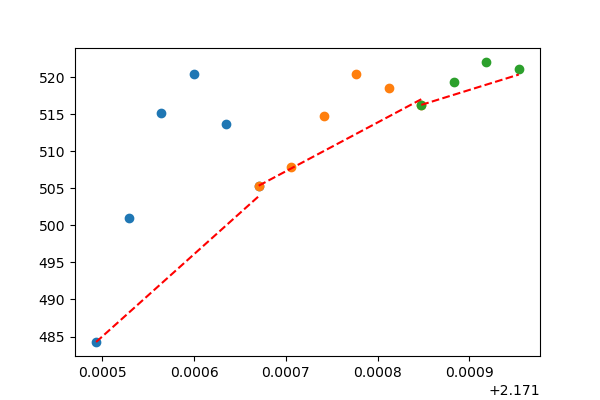

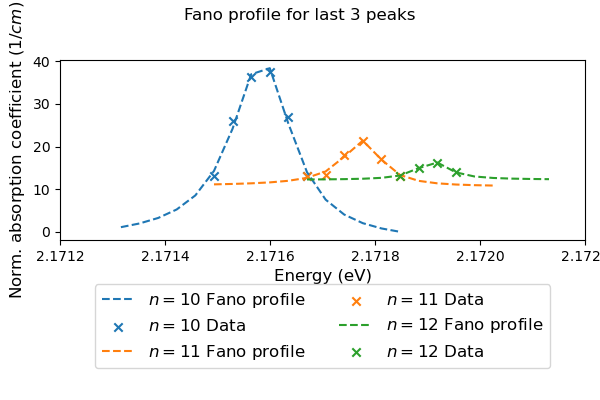

In [5]:
# Manual parameters to determine
manualQs = []
manualSs = []

# Manual paramters determined by eye
lastPeaks = [(1019,1025),(1024,1030),(1029,1033)]
manualWs = [0.0001063119445761096, 7.102452868457121e-05, 7.080551850036088e-05]
manualWs = [7.078471993038349e-05, 7.102452868457121e-05, 7.080551850036088e-05]

def line(x, x1, x2, y1, y2):
    # y = ax + b
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return a * x + b

def plot_straight_lines(spectrumR, energyR, valleys, ax):
    def line(x, x1, x2, y1, y2):
        # y = ax + b
        a = (y2 - y1) / (x2 - x1)
        b = y1 - a * x1
        return a * x + b

    spectrumR2 = [a for a in spectrumR]
    
    # Define the indices for the lines
    index_ranges = [(1019, valleys[-3]+1), (valleys[-3], valleys[-2]+1), (valleys[-2], valleys[-1]+1)]

    # Plot the straight lines
    for start, end in index_ranges:
        ax.plot(energyR[start:end], line(energyR[start:end], energyR[start], energyR[end], spectrumR[start], spectrumR[end]), 'r--')
        ax.scatter(energyR[start:end], spectrumR[start:end])
        spectrumR2[start:end] = spectrumR[start:end]-line(energyR[start:end], energyR[start], energyR[end], spectrumR[start], spectrumR[end])
    return spectrumR2


extra = 5

fig, ax = plt.subplots(figsize = (6,4))
spectrumR2 = plot_straight_lines(spectrumR, energyR, valleys, ax)


fig, ax = plt.subplots(figsize=(6, 4))

m = 0

fig.suptitle("Fano profile for last 3 peaks")
for i,p in enumerate(lastPeaks):
    
    bounds = ([np.NINF]*5 , [np.inf]*5)
    bounds[1][3] = 0.00014
    p0 = [1,1,1,0.000091,1]
    #0.00022364808522019845
    # Fano(E, Q, scaler, translation, E_n, lineWidth):
    if i == 0 or i == 1:
        fit, cov = curve_fit(lambda x, Q, s, t, w, h: Fano(x, Q, s, t, energyR[peaks[i+8]], w)+h, energyR[p[0]:p[1]], spectrumR2[p[0]:p[1]], maxfev = 1000000, p0=p0, bounds=bounds)
        
        y =  Fano(energyR[p[0]-extra:p[1]+extra], fit[0], fit[1], fit[2], energyR[peaks[i+8]], fit[3])+fit[4]
        if i == 0:
            m = min(y)
        
        ax.plot(energyR[p[0]-extra:p[1]+extra], 
               y+np.abs(m), label=f"$n = {i+10}$ Fano profile", linestyle="--")
        manualWs[i] = fit[3]

    else:
        fit, cov = curve_fit(lambda x, Q, s, t, h: Fano(x, Q, s, t, energyR[peaks[i+8]], manualWs[i])+h, energyR[p[0]:p[1]], spectrumR2[p[0]:p[1]], maxfev = 1000000)
        ax.plot(energyR[p[0]-extra:p[1]+extra], Fano(energyR[p[0]-extra:p[1]+extra], fit[0], fit[1], fit[2], energyR[peaks[i+8]], manualWs[i])+np.abs(m)+fit[3], label=f"$n = {i+10}$ Fano profile", linestyle="--")
        
    ax.scatter(energyR[p[0]:p[1]], spectrumR2[p[0]:p[1]]+np.abs(m), label =f"$n = {i+10}$ Data", marker="x")
    manualQs.append(fit[0])
    manualSs.append(fit[1])
    
ax.legend(fontsize=12, bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2)
plt.tight_layout()
plt.subplots_adjust(left=0.1, top = 0.85, bottom = 0.4)
ax.set_xticks(plt.xticks()[0][::2])
ax.set_yticks([0,10,20,30,40])
ax.set_xlabel("Energy (eV)", fontsize=12)
ax.set_ylabel("Norm. absorption coefficient ($1/cm$)",  fontsize=12)


### Finding areas

0 : 449 - 449
449 : 772 - 323
772 : 894 - 122
894 : 950 - 56
950 : 980 - 30
980 : 999 - 19
999 : 1010 - 11
1010 : 1018 - 8
1018 : 1024 - 6
1024 : 1029 - 5
1029 : 1032 - 3
11
11
[ 2  3  4  5  6  7  8  9 10 11 12]


/tmp/ipykernel_270/2391683290.py:42: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(lambda x, a, b: Splitting(x,a,b), np.array(two2twelve), areas)


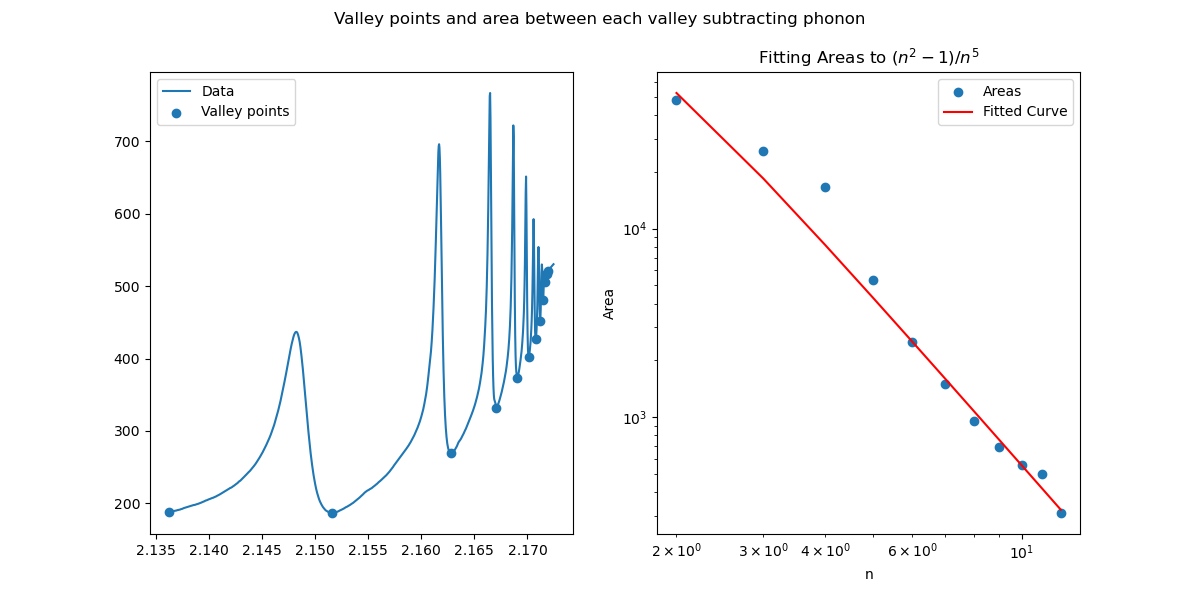

In [6]:
# def Phonon(E, c, h, E_n):
# 3 phonon backgrounds using the curve fitted parameters
P1 = Phonon(energyR[:-553], masterFit2[-2][0], masterFit2[-1], 2.115) # 2.115 from experimental data
P2 = Phonon(energyR[:-553], masterFit2[-2][1]*1.1, masterFit2[-1], energyR[peaks[0]])
P3 = Phonon(energyR[:-553], masterFit2[-2][2]*1.3, masterFit2[-1], energyR[peaks[2]])

two2twelve = np.array(range(2,13))
# Making an array starting with 0, and then having all the other valley indices
valleyPoints = [0]
for v in valleys:
    valleyPoints.append(v)

areas = []
for i in range(len(valleyPoints)-1):
    valley = valleyPoints[i]
    if i < len(valleyPoints)-1:
         nextValley = valleyPoints[i+1]
    else:
        nextValley = 1034
        
    print(f"{valley} : {nextValley} - {nextValley-valley}")
    peak = spectrumR[valley:nextValley]
    back = P1+P2+P3
    back = back[valley:nextValley]
    diff = peak-back
    area = np.sum(diff)
    areas.append(area)
    
# Define the function to fit
def Pstrength(n, a, b):
    return a*(n**2 - 1) / (n**5) + b

# Generate the data for n from 1 to 11
n_data = np.arange(2, 13)


# Define the function to fit
def Splitting(n,a,b):
    return ((n**2 - 1) / n**5)*a

# Perform the curve fit
popt, pcov = curve_fit(lambda x, a, b: Splitting(x,a,b), np.array(two2twelve), areas)

## Fit the data to the function
#popt, pcov = curve_fit(Pstrength, n_data, areas, maxfev = 2000000)

# Extract the optimized parameters
a_fit, b_fit = popt

fig, ax = plt.subplots(1, 2, figsize = (12,6))
fig.suptitle("Valley points and area between each valley subtracting phonon")

print(len(areas))
print(len(n_data))

ax[0].plot(energyR[:-553], spectrumR[:-553], label = "Data")
ax[0].scatter(energyR[valleyPoints], spectrumR[valleyPoints], label = "Valley points")
ax[0].legend()
# Plot the original data and the fitted curve
ax[1].scatter(n_data, areas, label='Areas')
ax[1].loglog(n_data, Pstrength(n_data, a_fit, b_fit), color='red', label='Fitted Curve')
ax[1].set_xlabel('n')
ax[1].set_ylabel('Area')
ax[1].set_title('Fitting Areas to $(n^2 - 1) / n^5$')
ax[1].legend()

print(n_data)

### Analyzing data


#### Initial fit of curve fit parameters and theoretical expectations

In [7]:
Q_ns = masterFit2[0]
S_ns = masterFit2[1]
widths = masterFit2[3]
E_g = 2.17208 # from https://www.nature.com/articles/nature13832.pdf  
def ExpRel(x,n,c):
    return c*np.real(np.power(x,n, dtype=complex))
def RydE(x, Ry, Eg):
    return Eg - Ry/np.power(x,2)

# Ranges
two2twelve = list(range(2, len(peaks)+2))
two2nine = list(range(2, len(peaks)-1))

fitEs, covEs         = curve_fit(lambda x, a: ExpRel(x, -2.0, a), two2twelve, E_g-energyR[peaks])
fitRy, covRy             = curve_fit(lambda x, Ry, Eg: RydE(x, Ry, Eg), two2twelve, energyR[peaks])
fitWidths, covWidths =  curve_fit(lambda x, a: ExpRel(x, -3.0, a),two2nine,widths[:-3])
fitCs, covCs         =  curve_fit(lambda x, a: ExpRel(x, -3.0, a),two2nine,S_ns[:-3])
fitAreas, covAreas   =  curve_fit(lambda x, a: ExpRel(x, -3.0, a),two2twelve,areas)
x_values = range(2, 13)  # Range from 2 to 12
y_values = [x_values, [x**2 for x in x_values], [x**3 for x in x_values], [x**4 for x in x_values]]

# Printing values used for uncertainty calculations
print(fitRy)
print(covRy)
print(print(np.sqrt(covRy[0,0])))
print(print(np.sqrt(covRy[1,1])))


[0.09758192 2.17256886]
[[1.02220117e-08 5.25017958e-10]
 [5.25017958e-10 7.63426896e-11]]
0.00010110396496895459
None
8.73743037513688e-06
None


#### Accounting for quantum defect in peak energy

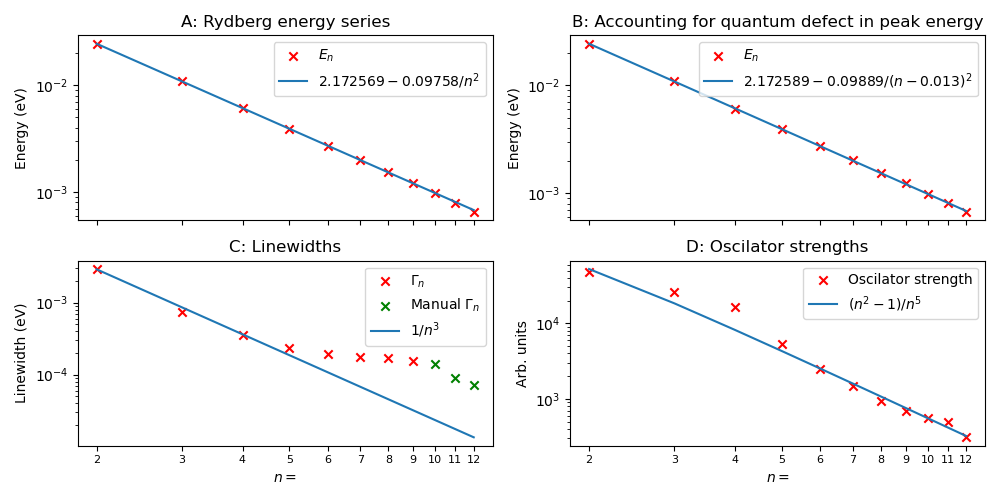

In [8]:
# Energy Quantum defect
def QuantumDefect(n, d, Ry, Eg):
    return Eg - Ry/(n-d)**2

E_g = 2.17208 # from https://www.nature.com/articles/nature13832.pdf  
fit, cov = curve_fit(lambda x, d, Ry, Eg: QuantumDefect(x, d, Ry, Eg), two2twelve, energyR[peaks], maxfev = 200000000)

fig,ax = plt.subplots(2,2, figsize=(10,5), sharex=True)
ax = ax.flatten()

ax[0].scatter(two2twelve, fitRy[1]-energyR[peaks], label="$E_n$", marker="x", color="red")
ax[0].loglog(two2twelve, fitRy[1]-RydE(two2twelve, *fitRy), label=f"${fitRy[1]:.6f}-{fitRy[0]:.5f}/n^2$")
ax[0].legend()
ax[0].set_xticks([])
ax[0].set_ylabel("Energy (eV)")
ax[0].set_title("A: Rydberg energy series")

ax[1].scatter(two2twelve, fit[2]-energyR[peaks], label="$E_n$", marker="x", color="red")
ax[1].loglog(two2twelve, fit[2]-QuantumDefect(two2twelve, *fit), label = f"${fit[2]:.6f}- {fit[1]:.5f}/(n{fit[0]:.3f})^2$")
ax[1].legend()
ax[1].set_xticks(two2twelve)
ax[1].get_xaxis().set_major_formatter(tck.ScalarFormatter())
ax[1].set_ylabel("Energy (eV)")
ax[1].set_title("B: Accounting for quantum defect in peak energy")

ax[2].set_title("C: Linewidths")
ax[2].scatter(two2nine, widths[:-3], label="$\Gamma_n$", marker="x", color="red")
ax[2].scatter([10, 11, 12], manualWs, label="Manual $\Gamma_n$", marker="x", color="green")
ax[2].loglog(two2twelve, ExpRel(two2twelve,-3,fitWidths[0]), label="$1/n^3$")
ax[2].set_ylabel("Linewidth (eV)")
ax[2].set_xlabel("$n = $")

ax[3].set_title("D: Oscilator strengths")
ax[3].scatter(two2twelve, areas, label ="Oscilator strength", color="red", marker="x")
ax[3].loglog(n_data, Pstrength(n_data, a_fit, b_fit), label='$(n^2-1)/n^5$')
ax[3].set_xlabel("$n = $")
ax[3].set_ylabel("Arb. units")

for i, ax in enumerate(ax.flat):
    ax.legend()
    ax.set_xticks(two2twelve)
    ax.get_xaxis().set_major_formatter(tck.ScalarFormatter())
    ax.tick_params(axis='x', labelsize=8)  # Decrease fontsize of x-axis ticks

plt.tight_layout()

In [9]:
# Printing used to get values and uncertainties
print(fit)
print(cov)
print(np.diag(cov))
print(np.sqrt(np.diag(cov)))
print(f"{np.sqrt(np.diag(cov)[1]):.3f}")

print(f"{fitRy}")
print(f"{np.sqrt(np.diag(covRy)[0]):.3e}")
print(f"{np.sqrt(np.diag(covRy)[1]):.3e}")


[-0.01330342  0.09889141  2.17258894]
[[ 2.73456480e-05 -2.70041908e-06 -4.12315266e-08]
 [-2.70041908e-06  2.73179058e-07  4.40287916e-09]
 [-4.12315266e-08  4.40287916e-09  1.09636900e-10]]
[2.73456480e-05 2.73179058e-07 1.09636900e-10]
[5.22930665e-03 5.22665341e-04 1.04707641e-05]
0.001
[0.09758192 2.17256886]
1.011e-04
8.737e-06


### Calculating the scaling coefficient to apply to the data

In [10]:
# n = 3 area
A = areas[1]

# Starting point of peak
start = valleys[0]
Estart = energyR[start]
Sstart = spectrumR[start]
Lstart = 1239.84193/ Estart # Wavelength (nm)

# Peak point
peak = peaks[1]
Epeak = energyR[peak]
Speak = spectrumR[peak]
Lpeak = 1239.84193/ Epeak # Wavelength (nm)

# Cu2O absorption data
lambda_axis = np.linspace(570, 580, 100000) 
ActLayer_data = (np.loadtxt('Data/TMM/Cu2O_nkvsnm_1.dat'))
nc = 3 + 1 * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                      ActLayer_data[:, 1]) - 1j * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                                                             np.flip(ActLayer_data[:, 2]))

# Closest index in lambda axis to valley wavelength
Vindex = min(range(len(lambda_axis)), key=lambda i: abs(lambda_axis[i]-Lstart))

# Closest index in lambda axis to peak wavelength
Pindex = min(range(len(lambda_axis)), key=lambda i: abs(lambda_axis[i]-Lpeak))

# Refractive index of Cu2O at that wavelength
Vrefr = nc[Vindex]
Prefr = nc[Pindex]

print(f"{Vrefr**2:.3f}")

# Difference
refr = Vrefr-Prefr
epsi = refr**2

# Determining the scaling
Cn = widths[1]*(epsi-Vrefr)/2
C = np.abs(Cn)
scaling = A/C

print(f"Energy of valley: {Estart}")
print(f"Wavelength of valley: {Lstart}")
print(f"Refractive index at valley: {Vrefr}")
print(f"Energy of peak: {Epeak}")
print(f"Wavelength of peak: {Lpeak}")
print(f"Refractive index at peak: {Prefr}")
print("\n")

print(f"The difference in refr is: {refr:.3f}")
print(f"Δε is {epsi:.2e}")
print("\n")

print(f"The scaling is thus {scaling:.3f}")

9.028-0.016j
Energy of valley: 2.1515668604256204
Wavelength of valley: 576.2507095664859
Refractive index at valley: (3.0047364174443056-0.0027242874999080726j)
Energy of peak: 2.1616719559654394
Wavelength of peak: 573.5569296620058
Refractive index at peak: (3.004985235794556-0.0013269726038720314j)


The difference in refr is: -0.000-0.001j
Δε is -1.89e-06+6.95e-07j


The scaling is thus 23571078.989


# Model

### Coupled oscilator model with 12 x 12 hamiltonian. Based on a 2x2 model created by Dr. Hamid Ohadi.

Defining real and imaginary components of cavity and excitonic energies, with the imaginary component representing the associated linewidth.

Defining a hamiltonian with the diagonal elements being the energies of the cavity and the excitons, with coupling constants in the first row and first collumn and all else 0.

Utilizing the eigenvalues of the hamiltonian to find the eigenenergies of the system, along with associated linewidths.

Linewidhs, excitonic energies, and oscilator strengths as determined from experimental data.

In [48]:
# Cavity energy
def Ec(k, gamma_c):
    return k**2/800 - 1j * gamma_c + 2.1425# Modulated with experimental factors

# Exciton energy
def Ex(k, gamma_x, detuning):
    return detuning - 1j * gamma_x

# 12 x 12 Ham, diag = Ec, Ex1, Ex2, ..., -g in rest of column 0 and row 0
def Ham(k, G, C, X, D):
    
    # Preparing diagonals for hamiltonian
    diags = [Ec(k, C)]
    for x, d in zip(X, D):
        diags.append(Ex(k, x, d))
    
    # Setting hamiltonian values
    out = np.identity(1+len(X), dtype="complex")
    for i in range(len(out[:, 0])):
        for j in range(len(out[0, :])):
            if i == j:
                out[i, j] = diags[i]
            elif i == 0:
                out[i, j] = -G[j-1]
            elif j == 0 and i != j:
                out[i, j] = -G[i-1]
                
    return out

# Real eigenvalues
def E0(k, G, C, X, D):
    eigenvalues, _ = eigh(Ham(k, G, C, X, D))
    return np.real(eigenvalues)

# Imaginary eigenvalues
def gamma(k, G, C, X, D):
    eigenvalues, _ = eig(Ham(k, G, C, X, D))
    return np.imag(eigenvalues)

# Constants
gamma_c = 7.418957635740853e-05 #FROM TMM CALCULATIONS

# Experimental constants:
# Linewidhs - determined from absorption peaks of experimental data
X =  widths[:-3]+manualWs
# Energies - determined as peak energies of experimental absorption data
D = energyR[peaks]
# Oscilator strengths - determined from the areas of experimental absorption peaks
G = areas
G = [x/scaling for x in G] # Scaling by a factor calculated via experimental data

### Plotting cavity, exciton, and polariton energies

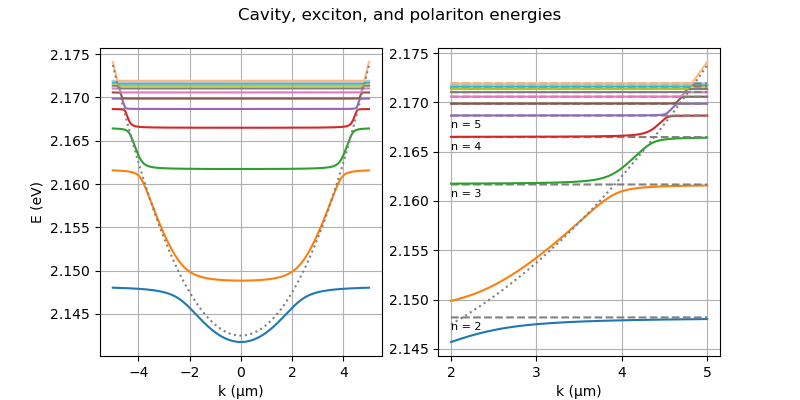

In [56]:
# Plotting polariton energies
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78']

# Range of k values
k_values = [np.linspace(-5,5,10000), np.linspace(2, 5, 10000)]

# Plot results
fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig.suptitle('Cavity, exciton, and polariton energies')

for l,ks in enumerate(k_values):
    # Calculate eigenvalues for each k value
    Es = []
    for k in ks:
        E = E0(k, G, gamma_c, X, D)
        Es.append(E)

    for i in range(len(Es[0])):
            if i == 0 and l == 0:
                ax[l].plot(ks, [E[i] for E in Es], label = "Lowest polariton", color=colors[i])
            elif i == 11 and l == 0:
                ax[l].plot(ks, [E[i] for E in Es], label = "Highest polariton", color=colors[i])
            elif i > 0 and l == 0:
                ax[l].plot(ks, [E[i] for E in Es], color=colors[i])
            if l == 1:
                ax[l].plot(ks, [E[i] for E in Es], color=colors[i], label = f"Pol {i+1}")
                
                if i < 4:
                    # Annotate the start of each line
                    plt.annotate(f'n = {i+2}', xy=(ks[0], D[i]), xytext=(ks[0], D[i]-0.001),
                    fontsize=8, ha='left', va='center')

            if i != 11 and l == 1:
                ax[l].plot(ks, [D[i]]*len(ks), linestyle="--", color="gray")
                
    if l == 0:
        ax[l].plot(ks, np.real(Ec(ks, gamma_c)), label='Cavity energy', linestyle=':', color='gray')
        ax[l].set_ylabel('E (eV)')
    if l == 1:
        ax[l].plot(ks, np.real(Ec(ks, gamma_c)), linestyle=':', color='gray')
    ax[l].set_xlabel('k (μm)')
    ax[l].grid(True)


### Hopfield coefficients

Denoting the contribution of each polariton mode at a given energy

### Plotting hopfield coefficients comparing simple single exciton case to our case.

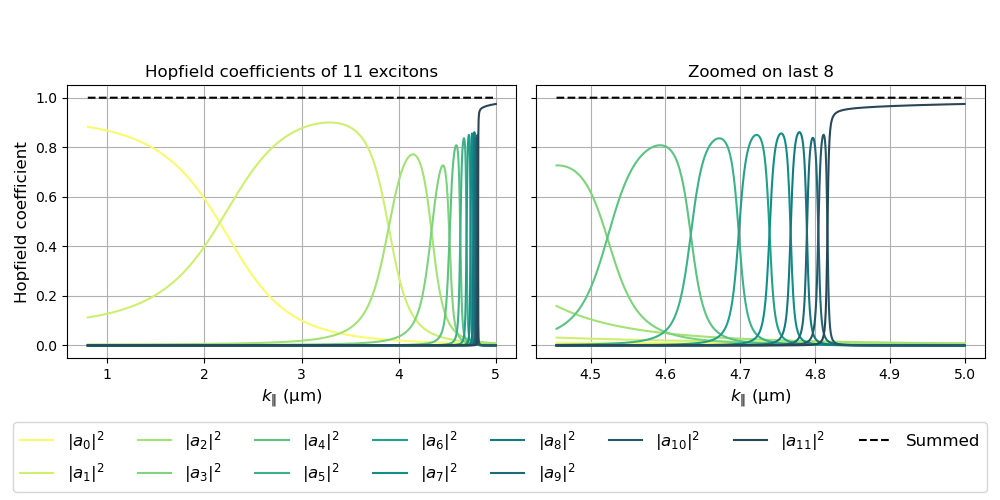

CPU times: user 2.91 s, sys: 11.5 ms, total: 2.92 s
Wall time: 2.91 s


In [57]:
%%time
import numpy as np
import matplotlib.pyplot as plt

# Function returning array of the hopfield coefficients
def Hopfield(k, G, gamma_c, X, D, n):
    Vals = np.abs(eigh(Ham(k, G, gamma_c, X, D))[1][n])**2
    return Vals

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

k_values2 = np.linspace(0.8, 5, 10000)

Vals = []
for k in k_values2:
    Vals.append(Hopfield(k, G, gamma_c, X, D, 0))

start = 8700
stop = 10000
V = [[]]*13
V2 = [[]]*13
for i in range(12):
    V[i] = [v[i] for v in Vals]
    V2[i] = [v[i] for v in Vals[start:stop]]
V[12] = [np.sum(v) for v in Vals]
V2[12] = [np.sum(v) for v in Vals[start:stop]]

colors  = [
"#fafa6e",
"#ceef70",
"#a4e275",
"#7fd37d",
"#5cc383",
"#3db288",
"#23a089",
"#128e87",
"#137b80",
"#1d6976",
"#255767",
"#294656"
]

for i in range(12):
    ax[0].plot(k_values2, V[i], label=fr"$|a_{{{i}}}|^2$", color=colors[i])
    ax[1].plot(k_values2[start:stop], V2[i], color=colors[i])

ax[0].plot(k_values2, V[12], label="Summed", color="Black", linestyle="--")
ax[1].plot(k_values2[start:stop], V2[12], color="Black", linestyle="--")

Vals = []
for k in k_values[0]:
    Vals.append(Hopfield(k, G, gamma_c, X, D, 0))

V = [[]]*12
for i in range(12):
    V[i] = [v[i] for v in Vals]


ax[0].set_title("Hopfield coefficients of 11 excitons")
ax[0].set_ylabel("Hopfield coefficient", fontsize=12)
ax[0].set_xlabel("$k_‖$ (μm)", fontsize=12)
ax[1].set_xlabel("$k_‖$ (μm)", fontsize=12)
ax[0].grid(True)
ax[1].grid(True)
ax[1].set_title("Zoomed on last 8")


# Creating a single legend for both subplots and placing it below the subplots
fig.legend(fontsize=12, loc='lower center',  bbox_to_anchor=(0.5, 0), shadow=False, ncol=8)

plt.tight_layout(rect=[0, 0.15, 1, 0.9])
plt.show()


### Determining splittings

Determining the energy splittings at each of the avoided crossings of the polariton modes

In [60]:
# Returning the index of the item in a list closest to the input   
def Closest_index(value, lst):
    closest_element = None
    min_difference = float('inf')
    closest_index = None
    for index, element in enumerate(lst):
        difference = abs(element - value)
        if difference < min_difference:
            closest_element = element
            min_difference = difference
            closest_index = index
    return closest_index

### Treating each avoided crossing as a local 2 x 2 case to determine the energy splitting between the upper and lower polariton at that point.

11it [00:00, 26.57it/s]
/tmp/ipykernel_270/194134337.py:93: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(rect=[0, 0, .3, 1.2])


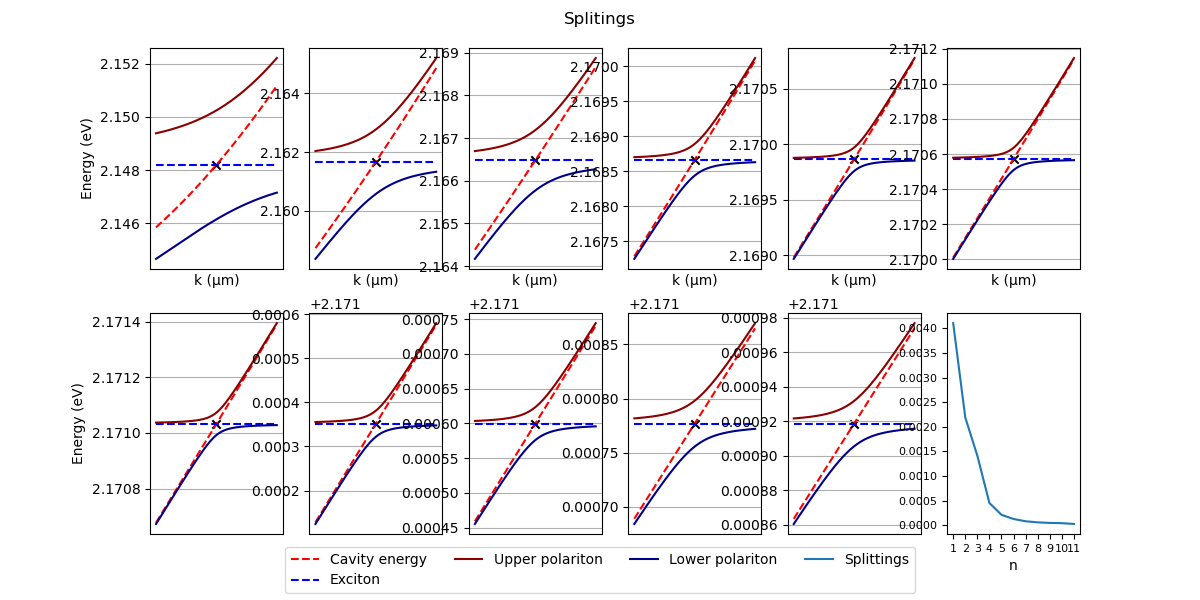

In [82]:
# 2 x 2 Hamiltonian
def HamS(k, g, gamma_c, gamma_x, detuning):
    
    out = np.identity(2, dtype="complex")
    out[0,0] = Ec(k, gamma_c)
    out[1,1] = Ex(k,gamma_x,detuning)
    out[1,0] = -g
    out[0,1] = -g
                 
    return out

# Real eigenvalues
def E0S(k, G, C, X, D):
    eigenvalues, _ = eigh(HamS(k, G, C, X, D))
    return np.real(eigenvalues)

# Imaginary eigenvalues
def gammaS(k, G, C, X, D):
    eigenvalues, _ = eig(Ham(k, G, C, X, D))
    return np.imag(eigenvalues)
# Range of k values
factor = .5
D_mod = [(d-2.1425)*800 for d in D]

# Plot results
fig, ax = plt.subplots(2, 6, figsize=(12, 6))
fig.suptitle('Splitings')
plt.tick_params(axis='both', which='major', labelsize=8)

ax = ax.flatten()

k_intersections = []
splittings = []

for i, a in tqdm(enumerate(ax[:-1])):
    
    # k values around splitting point
    ks = np.linspace(D_mod[i]**0.5-factor, D_mod[i]**0.5+factor, 1000)
    factor = factor/1.6
    
    exciton = [D[i]]*len(ks)
    cavity = np.real(Ec(ks, gamma_c))
    
    a.plot(ks, cavity, label='Cavity energy', linestyle='--', color='red')
    a.plot(ks, exciton, label="Exciton", linestyle ="--", color ="blue")
    
    closest_i = Closest_index(D[i], cavity)
    closest_k = ks[closest_i]
    a.scatter(closest_k, D[i], marker="x", color="black")
    k_intersections.append(closest_k)
    
    # Calculate eigenvalues for each k value
    Es = []
    
    for k in ks:
        E = E0S(k, G[i], gamma_c, X[i], D[i])
        Es.append(E)
    
    upperPolariton = [E[1] for E in Es]
    lowerPolariton = [E[0] for E in Es]
    
    splittings.append(upperPolariton[closest_i]-lowerPolariton[closest_i])
    
    a.plot(ks, upperPolariton, label='Upper polariton', color='darkred')
    a.plot(ks, lowerPolariton, label="Lower polariton", color ="darkblue")

    
    a.set_xticks([])
    
    a.grid(True)
    if i < 6:
        a.set_xlabel("k (μm)")
    if i==0 or i == 6:
        a.set_ylabel('Energy (eV)')

ax[11].plot(range(1,12), splittings, label="Splittings")
ax[11].set_xlabel("n")
ax[11].set_xticks(range(1,12))

# Legend for cavity energy and exciton
legend_cavity = plt.Line2D([0], [0], linestyle='--', color='red', label='Cavity energy')
legend_exciton = plt.Line2D([0], [0], linestyle='--', color='blue', label='Exciton')

# Legend for upper and lower polaritons
legend_upper_polariton = plt.Line2D([0], [0], color='darkred', label='Upper polariton')
legend_lower_polariton = plt.Line2D([0], [0], color='darkblue', label='Lower polariton')
legend_splittings = plt.Line2D([0], [0], color='tab:blue', label='Splittings')

# Combine both legends
plt.figlegend(handles=[legend_cavity, legend_exciton, legend_upper_polariton, legend_lower_polariton, legend_splittings], 
              loc='lower center', ncol=4)

plt.tight_layout(rect=[0, 0, .3, 1.2])
plt.subplots_adjust(top=0.92)

### Comparing the splittings to theoretical limitations

/tmp/ipykernel_270/3806643230.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(lambda x, a, b: Splitting(x,a,b), np.array(two2twelve), splittings)


Text(0.5, 1.0, 'Energy splittings for compared to linewidth limitations')

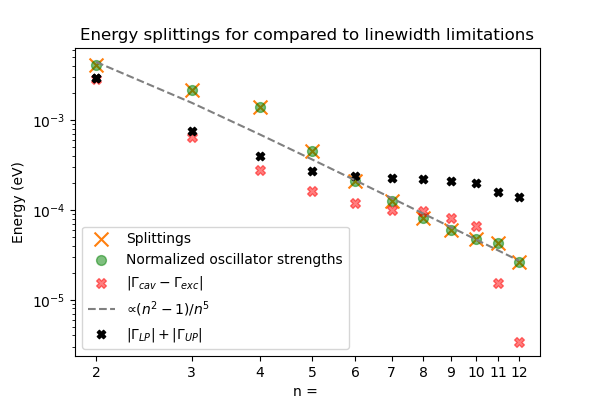

In [83]:
# Define the function to fit
def Splitting(n,a,b):
    return ((n**2 - 1) / n**5)*a

two2twelve = np.arange(2,13)

# Curve fitting splittings to Splitting function
popt, pcov = curve_fit(lambda x, a, b: Splitting(x,a,b), np.array(two2twelve), splittings)

# Normalizing the coupling constans
G_norm = G[:]
G_norm = [g*(splittings[0]/G[0]) for g in G_norm]

# Plotting normalized splittins alongside theoretical limitatitons
fig, ax = plt.subplots(figsize = (6,4))
plt.scatter(two2twelve, splittings, label="Splittings", marker="x", color="tab:orange", alpha=1, s=100)
plt.scatter(two2twelve, G_norm, label="Normalized oscillator strengths", marker="o", color="green", alpha=0.5, s=50)
plt.scatter(two2twelve, np.abs([(gamma_c-x) for x in X]), label="$|\Gamma_{cav} - \Gamma_{exc}|$", marker="X", color="red", alpha=0.5, s=50)

# Plotting the curve fit
plt.loglog(two2twelve, Splitting(np.array(two2twelve), popt[0], popt[1]), label ="$∝ (n^2-1)/n^5$", color="gray", linestyle = "--")

for i in range(11):
    Hop = Hopfield(k_intersections[i], G, gamma_c, X, D, 0)
    Hop = np.sort(Hop)
    UP = Hop[-1]
    LP = Hop[-2]
    plt.scatter(i+2, (UP*gamma_c+LP*gamma_c+UP*X[i]+LP*X[i]), color="black", marker="X")
    if i == 0:
        plt.scatter(i+2, (UP*gamma_c+LP*gamma_c+UP*X[i]+LP*X[i]), color="black", marker="X", label="$|\Gamma_{LP}| + |\Gamma_{UP}|$")

ax.set_ylabel("Energy (eV)")
ax.set_xlabel("n = ")
ax.set_xticks(two2twelve)
ax.get_xaxis().set_major_formatter(tck.ScalarFormatter())
plt.legend()
ax.set_title("Energy splittings for compared to linewidth limitations")

## Intensity graphs

Showing the intensity of our polariton formation at given energies and momenta

In [84]:
import math
from matplotlib.patches import Rectangle

gamma_c = 7.418957635740853e-05# FROM TMM CALCULATIONS

# Returns the polariton intensities
def PolI(k, G, C, X, D, E):

    # Array of the eigenvectors of the hamiltonian
    eigenvectors     = eigh(Ham(k, G, C, X, D))[1]

    # First eigenvector only
    first_eigenvect  = eigenvectors[0, :]

    # Length of first eigenvector
    vect = np.abs(first_eigenvect)**2

    # Imaginary eigenvalues absolute values squared
    gamma_squared = np.abs(gamma(k, G, C, X, D))**2
    
    # Real eigenvalues absolute difference to the parameter energy squared 
    energy_squared = (E-E0(k, G, C, X, D))**2

    # Dispersion relation
    dispersion = gamma_squared/(gamma_squared + energy_squared)

    # Returning dispersion modulated by the vector length
    return vect*dispersion

# Total intensity
def TotI(k, G, C, X, D, E):
    P = PolI(k, G, C, X, D, E)
    return np.sum(P)

### Intensity using experimental parameters

100it [00:04, 21.38it/s]


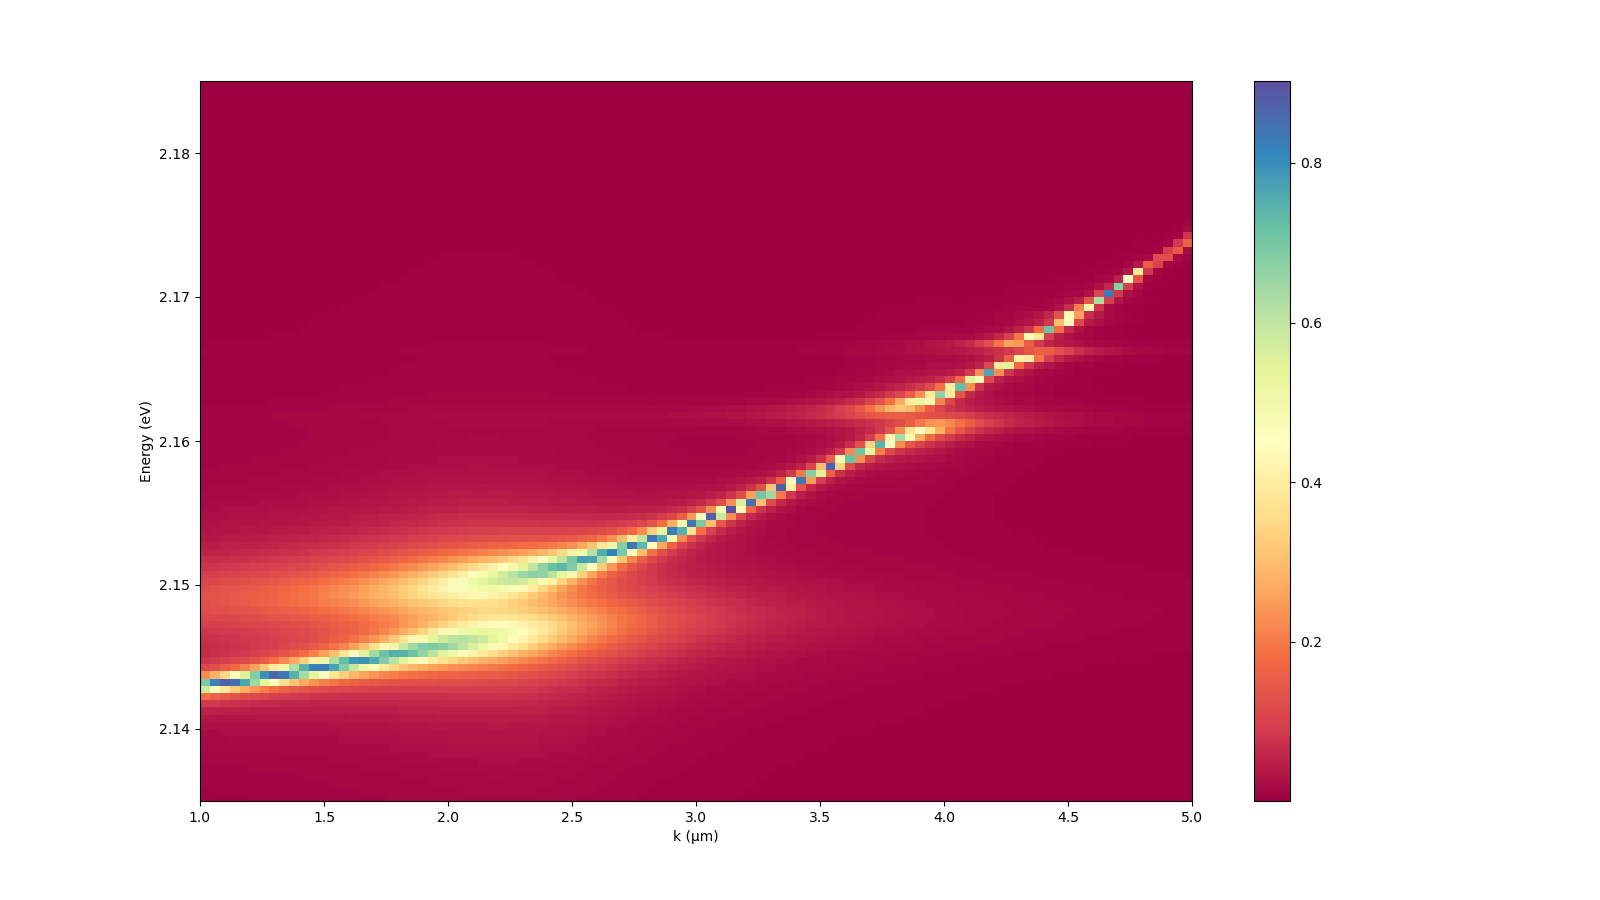

In [101]:
# Calculating the intensity and returning it as a plottable 2D array
def calc(k, G, C, X, D, kParam, eParam, resolution): # Resolution = [xRes, yRes]
    # Create grid of k and energy values
    k_values = np.linspace(kParam[0], kParam[1], resolution[0])
    energy_values = np.linspace(eParam[0], eParam[1], resolution[1])
        
    # Calculate total intensity for each (k, energy) pair
    total_intensity = np.zeros((len(energy_values), len(k_values)))  # Transpose the array

    for i, energy in tqdm(enumerate(energy_values)):
        for j, k in enumerate(k_values):
            total_intensity[i, j]  = TotI(k, G, C, X, D, energy)
    
    return total_intensity

# Running the caulations for an array of x and y parameters
def calcI(params, eArr, kArr, resolution):
    out = []

    # Different caulation parameters
    for i,param in enumerate(params):
        eParams = eArr[i]
        kParams = kArr[i]

        # Different calculation ranges
        for n,eParam in enumerate(eParams):
            kParam = kParams[n]
            out.append(calc(*param, kParam, eParam, resolution))
        
    return out

# E and k ranges
eParams = [(2.135, 2.185)]
kParams = [(1,5)]

# Using the same twice
eArr = [eParams, eParams]
kArr = [kParams, kParams]

# Araray of all the intensities
intensities1 = calcI([[k, G, gamma_c, X, D]], eArr, kArr, [100,100])

# Plotting all intensities
fig, ax = plt.subplots(1,1, figsize=(16,9))
for i, intensity in enumerate(intensities1):
    if i == 0 or i == 2:
        kParam = kParams[0]
        eParam = eParams[0]
    if i == 1 or i == 3:
        kParam = kParams[1]
        eParam = eParams[1]
        
    im = ax.imshow(intensity, extent=[kParam[0], kParam[1], eParam[0], eParam[1]], aspect='auto', origin='lower', cmap='Spectral')
    ax.set_xlabel('k (μm)')
    ax.set_ylabel('Energy (eV)')
    
plt.subplots_adjust(wspace=0.3, hspace=0.35, top=0.91)    
fig.colorbar(im, ax=ax)


### Intensity with and without coupling

100it [00:04, 22.10it/s]
100it [00:04, 23.90it/s]
100it [00:02, 40.04it/s]
100it [00:02, 39.57it/s]


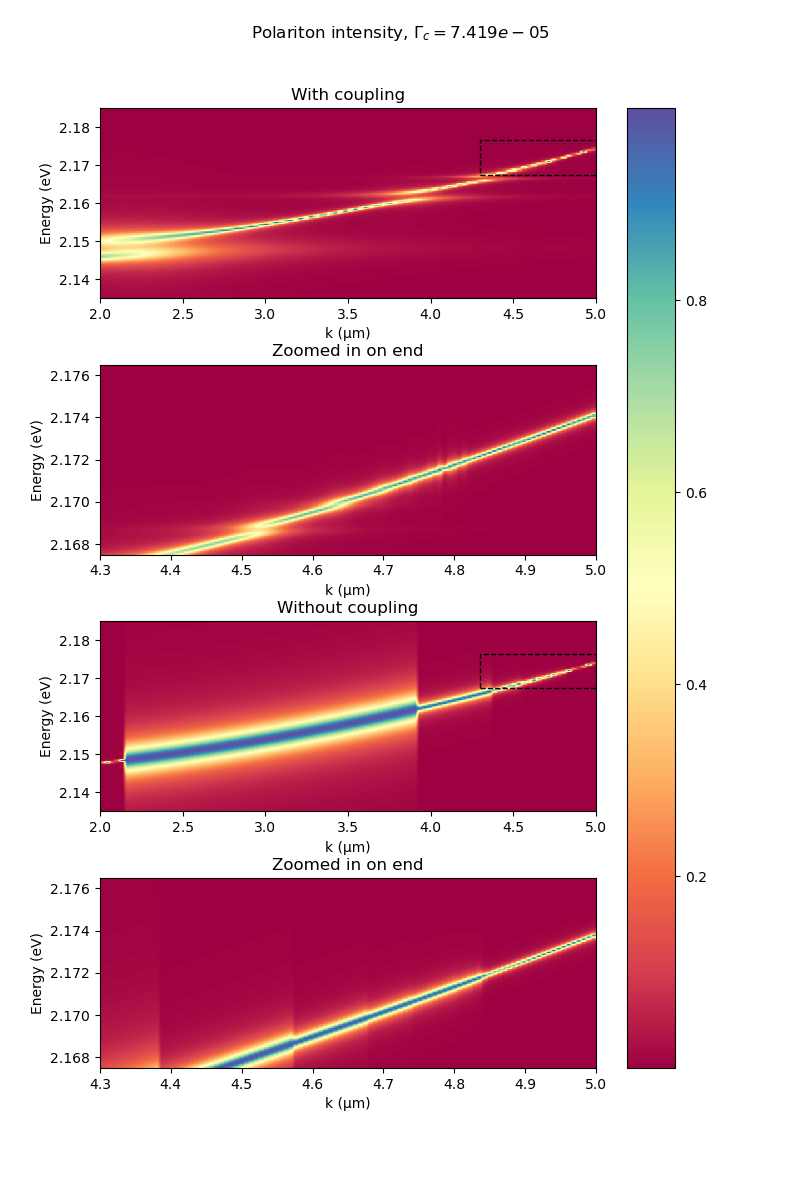

In [102]:
eParams = [(2.135, 2.185), (2.1675, 2.1765)]
kParams = [(2,5), (4.3,5)]

eArr = [eParams, eParams]
kArr = [kParams, kParams]

intensities1 = calcI([[k, G, gamma_c, X, D], [k, [0 for g in G], gamma_c, X, D]], eArr, kArr, [100,100])

fig, ax = plt.subplots(4,1, figsize=(8,12))
ax = ax.flatten()

for i, intensity in enumerate(intensities1):
    if i == 0 or i == 2:
        kParam = kParams[0]
        eParam = eParams[0]
    if i == 1 or i == 3:
        kParam = kParams[1]
        eParam = eParams[1]
        
    
    im = ax[i].imshow(intensity, extent=[kParam[0], kParam[1], eParam[0], eParam[1]], aspect='auto', origin='lower', cmap='Spectral')
    ax[i].set_xlabel('k (μm)')
    ax[i].set_ylabel('Energy (eV)')
    
    # Add zoom box to the second set of subplots
    if i == 0 or i == 2:
        rect = Rectangle((kParams[1][0], eParams[1][0]), kParams[1][1] - kParams[1][0],
                             eParams[1][1] - eParams[1][0], linewidth=1, edgecolor='black', facecolor='none',
                             linestyle='--')
        ax[i].add_patch(rect)
    
ax[0].set_title("With coupling")
ax[2].set_title("Without coupling")
ax[1].set_title("Zoomed in on end")
ax[3].set_title("Zoomed in on end")
plt.suptitle(f"Polariton intensity, $Γ_c = {gamma_c:.3e}$")
plt.subplots_adjust(wspace=0.3, hspace=0.35, top=0.91)    
fig.colorbar(im, ax=ax)


### Intensities with decreased linewidhts and with increased coupling 

100it [00:05, 19.75it/s]
100it [00:04, 23.70it/s]
100it [00:04, 23.50it/s]
100it [00:04, 23.29it/s]


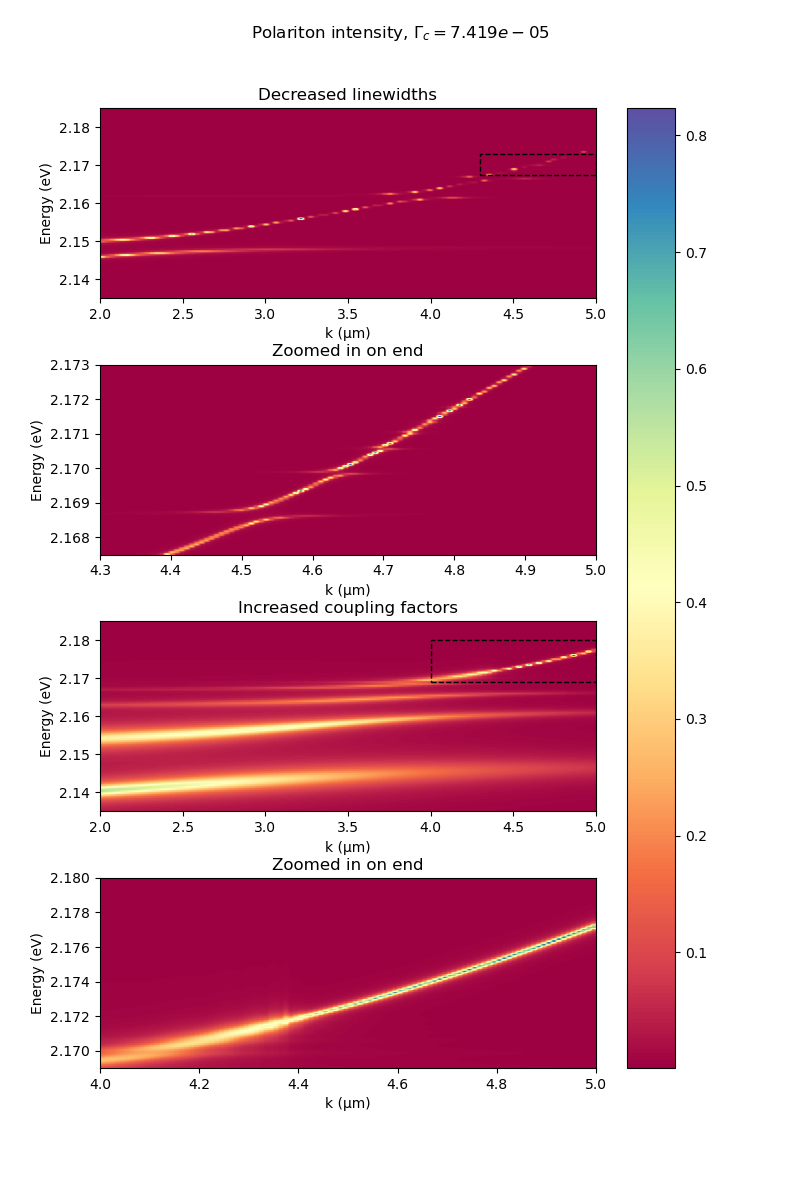

In [104]:
eParams = [(2.135, 2.185), (2.1675, 2.173)]
kParams = [(2,5), (4.3, 5)]

eParams2 = [(2.135, 2.185), (2.169, 2.18)]
kParams2 = [(2,5), (4,5)]

eArr = [eParams, eParams2]
kArr = [kParams, kParams2]

factor1 = 0.1
factor2 = 3.5

intensities2 = calcI([[k, G, gamma_c*factor1, [x*factor1 for x in X], D], [k, [g*factor2 for g in G], gamma_c, X, D]], eArr, kArr, [100,100])

fig, ax = plt.subplots(4,1, figsize=(8,12))
ax = ax.flatten()

for i, intensity in enumerate(intensities2):
    if i == 0:
        kParam = kParams[0]
        eParam = eParams[0]
    if i == 2:
        kParam = kParams2[0]
        eParam = eParams2[0]
    if i == 1:
        kParam = kParams[1]
        eParam = eParams[1]
    if i == 3:
        kParam = kParams2[1]
        eParam = eParams2[1]
        
    im = ax[i].imshow(intensity, extent=[kParam[0], kParam[1], eParam[0], eParam[1]], aspect='auto', origin='lower', cmap='Spectral')
    ax[i].set_xlabel('k (μm)')
    ax[i].set_ylabel('Energy (eV)')
    
    # Add zoom box to the second set of subplots
    if i == 0:
        rect = Rectangle((kParams[1][0], eParams[1][0]), kParams[1][1] - kParams[1][0],
                             eParams[1][1] - eParams[1][0], linewidth=1, edgecolor='black', facecolor='none',
                             linestyle='--')
        ax[i].add_patch(rect)
        
    # Add zoom box to the second set of subplots
    if i == 2:
        rect = Rectangle((kParams2[1][0], eParams2[1][0]), kParams2[1][1] - kParams2[1][0],
                             eParams2[1][1] - eParams2[1][0], linewidth=1, edgecolor='black', facecolor='none',
                             linestyle='--')
        ax[i].add_patch(rect)
    
ax[0].set_title("Decreased linewidths")
ax[2].set_title("Increased coupling factors")
ax[1].set_title("Zoomed in on end")
ax[3].set_title("Zoomed in on end")
plt.suptitle(f"Polariton intensity, $Γ_c = {gamma_c:.3e}$")
plt.subplots_adjust(wspace=0.3, hspace=0.35, top=0.91)    
fig.colorbar(im, ax=ax)

### Intensities using various cavity linewidth multipliers

100it [00:05, 18.58it/s]
100it [00:05, 19.62it/s]
100it [00:04, 20.77it/s]
100it [00:04, 23.76it/s]


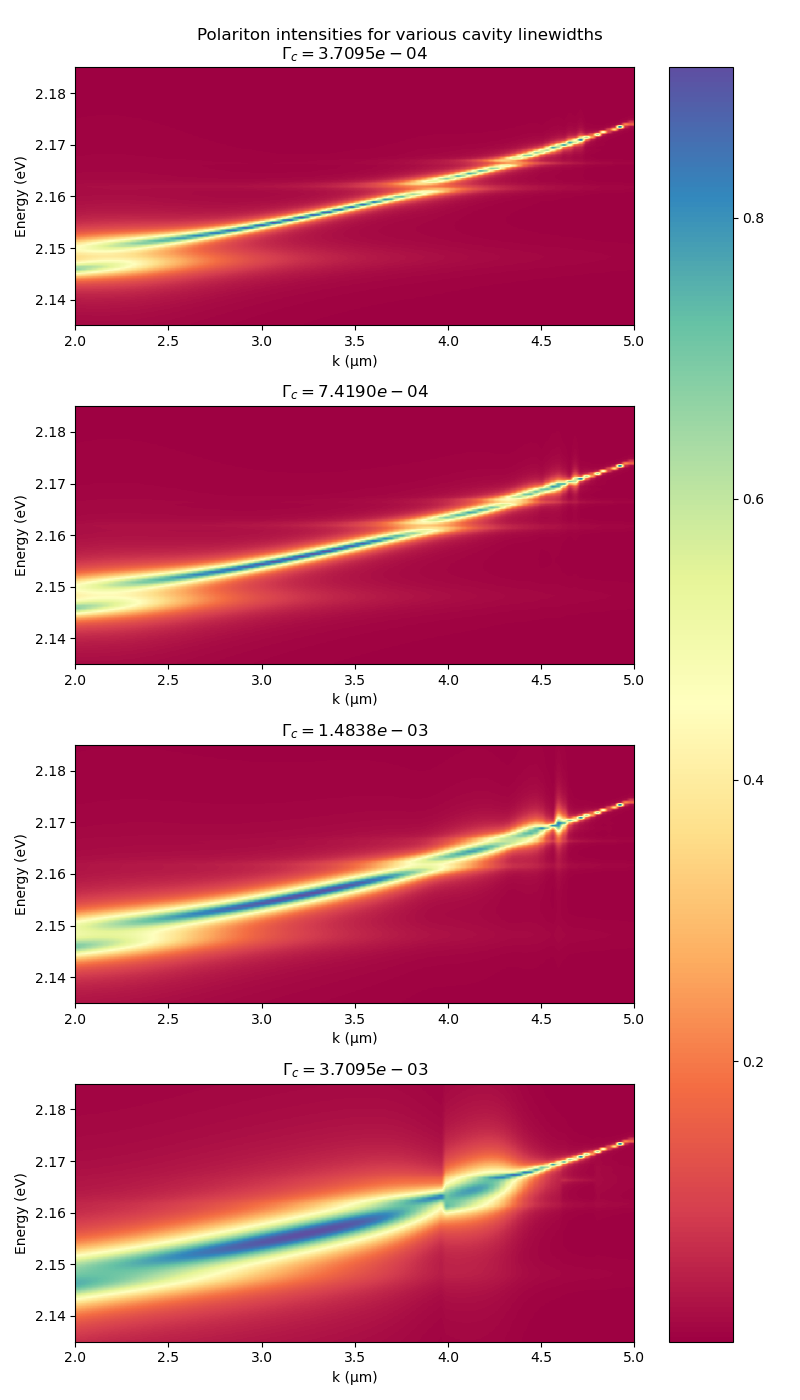

In [105]:
C = [5, 10, 20, 50]
eParams = [(2.135, 2.185)]
kParams = [(2,5)]
EParam = eParams[0]
kParam = kParams[0]
eArr = [eParams,eParams,eParams,eParams]
kArr = [kParams,kParams,kParams,kParams]

intensities3 = calcI([[k, G, gamma_c*C[0], X, D],[k, G, gamma_c*C[1], X, D],[k, G, gamma_c*C[2], X, D], [k, G, gamma_c*C[3], X, D]], eArr, kArr, [100,100])

fig,ax=plt.subplots(4,1, figsize=(8,14))
fig.suptitle("Polariton intensities for various cavity linewidths")

kParam = kParams[0]
eParam = eParams[0]
for i, intensity in enumerate(intensities3):
    im = ax[i].imshow(intensity, extent=[kParam[0], kParam[1], EParam[0], EParam[1]], aspect='auto', origin='lower', cmap='Spectral')
    ax[i].set_title(f'$Γ_c = {gamma_c*C[i]:.4e}$')
    ax[i].set_xlabel('k (μm)')
    ax[i].set_ylabel('Energy (eV)')
    
plt.tight_layout()
fig.colorbar(im, ax=ax)

### All intensities plotted together

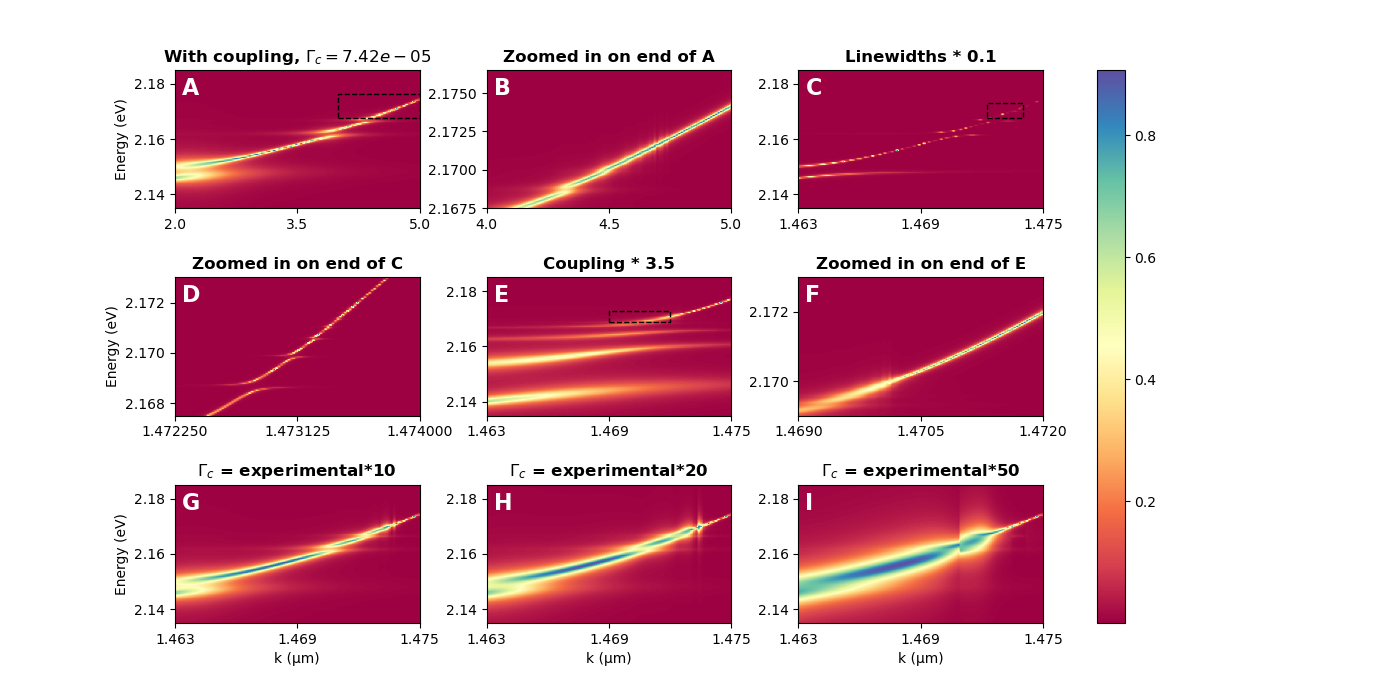

In [106]:
fig, ax = plt.subplots(3,3, figsize = (14,7))
ax = ax.flatten()
eParams = [(2.135, 2.185), (2.1675, 2.1765)]
kParams = [(2,5), (4,5)]
for i, intensity in enumerate(intensities1[:-2]):
    if i == 0 or i == 2:
        kParam = kParams[0]
        eParam = eParams[0]
    if i == 1 or i == 3:
        kParam = kParams[1]
        eParam = eParams[1]
        
    im = ax[i].imshow(intensity, extent=[kParam[0], kParam[1], eParam[0], eParam[1]], aspect='auto', origin='lower', cmap='Spectral')
    ax[i].set_xticks((np.linspace(kParam[0], kParam[1], 3)))
    
    # Add zoom box to the second set of subplots
    if i == 0 or i == 2:
        rect = Rectangle((kParams[1][0], eParams[1][0]), kParams[1][1] - kParams[1][0],
                             eParams[1][1] - eParams[1][0], linewidth=1, edgecolor='black', facecolor='none',
                             linestyle='--')
        ax[i].add_patch(rect)
    
ax[0].set_title(f"With coupling, $Γ_c = {gamma_c:.2e}$", fontweight='bold')
ax[1].set_title("Zoomed in on end of A", fontweight='bold')

eParams = [(2.135, 2.185), (2.1675, 2.173)]
kParams = [(1.463,1.475), (1.47225, 1.474)]
eParams2 = [(2.135, 2.185), (2.169, 2.173)]
kParams2 = [(1.463,1.475), (1.4690, 1.472)]

for i, intensity in enumerate(intensities2):
    if i == 0:
        kParam = kParams[0]
        eParam = eParams[0]
    if i == 2:
        kParam = kParams2[0]
        eParam = eParams2[0]
    if i == 1:
        kParam = kParams[1]
        eParam = eParams[1]
    if i == 3:
        kParam = kParams2[1]
        eParam = eParams2[1]
        
    im = ax[i+2].imshow(intensity, extent=[kParam[0], kParam[1], eParam[0], eParam[1]], aspect='auto', origin='lower', cmap='Spectral')
    ax[i+2].set_xticks((np.linspace(kParam[0], kParam[1], 3)))

    # Add zoom box to the second set of subplots
    if i == 0:
        rect = Rectangle((kParams[1][0], eParams[1][0]), kParams[1][1] - kParams[1][0],
                             eParams[1][1] - eParams[1][0], linewidth=1, edgecolor='black', facecolor='none',
                             linestyle='--')
        ax[i+2].add_patch(rect)
        
    # Add zoom box to the second set of subplots
    if i == 2:
        rect = Rectangle((kParams2[1][0], eParams2[1][0]), kParams2[1][1] - kParams2[1][0],
                             eParams2[1][1] - eParams2[1][0], linewidth=1, edgecolor='black', facecolor='none',
                             linestyle='--')
        ax[i+2].add_patch(rect)
    ax[i+2].set_xticks((np.linspace(kParam[0], kParam[1], 3)))

    
ax[2].set_title(f"Linewidths * {factor1}", fontweight='bold')
ax[3].set_title("Zoomed in on end of C", fontweight='bold')

ax[4].set_title(f"Coupling * {factor2}", fontweight='bold')
ax[5].set_title("Zoomed in on end of E", fontweight='bold')

eParams = [(2.135, 2.185)]
kParams = [(1.463,1.475)]
kParam = kParams[0]
eParam = eParams[0]

for i, intensity in enumerate(intensities3[1:]):
    im = ax[i+6].imshow(intensity, extent=[kParam[0], kParam[1], EParam[0], EParam[1]], aspect='auto', origin='lower', cmap='Spectral')
    ax[i+6].set_title(f'$Γ_c$ = experimental*{C[i+1]}', fontweight='bold')
    ax[i+6].set_xlabel('k (μm)')
    ax[i+6].set_xticks((np.linspace(kParam[0], kParam[1], 3)))

# Annotate each subplot with the corresponding letter of the alphabet
letters = ['A','B','C','D','E','F','G', 'H','I']
for i, a in enumerate(ax.flat):
    a.annotate(letters[i], xy=(0, 1), xycoords='axes fraction', fontsize=16,
                xytext=(5, -5), textcoords='offset points', ha='left', va='top', color="white", fontweight='bold')

ax[0].set_ylabel('Energy (eV)')
ax[3].set_ylabel('Energy (eV)')
ax[6].set_ylabel('Energy (eV)')

    
plt.subplots_adjust(wspace=0.275, hspace=0.5, top=0.9)    
fig.colorbar(im, ax=ax)


### Linewdith dependent on energy

TMM calculations allow us to relate the energy used to gamma_c

100it [00:04, 22.71it/s]


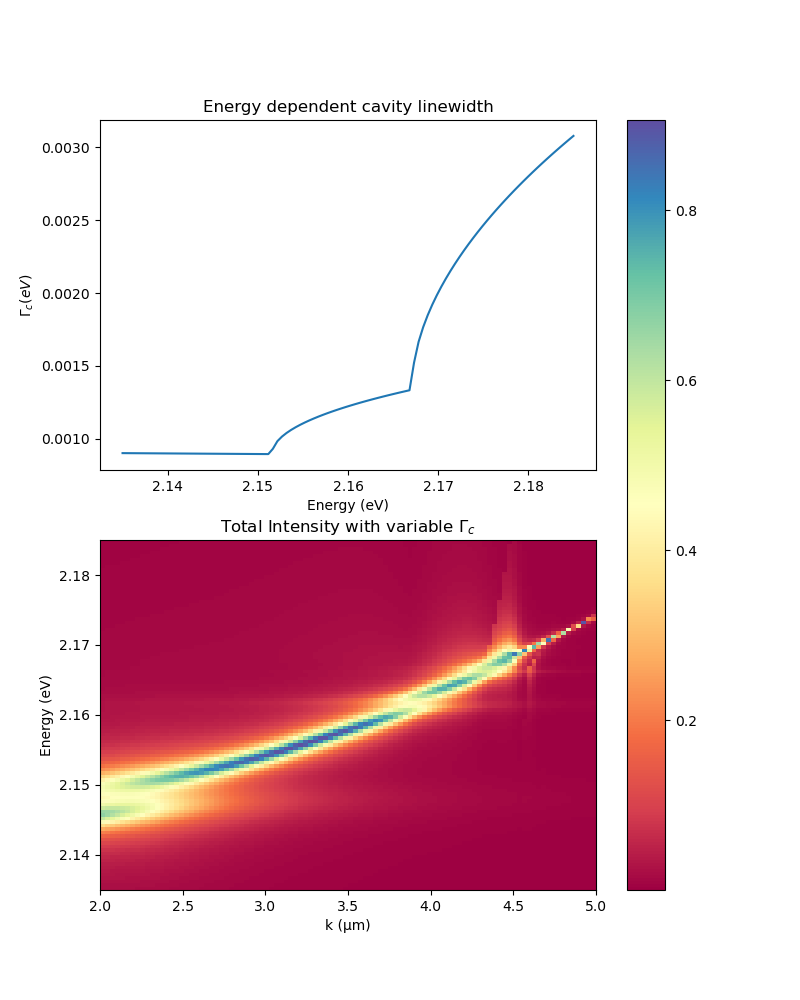

In [107]:
# Phonon background as a function of energy
def a(E):
    E = np.array([E])
    # Using phonon shapes from curve fit
    P1 = Phonon(E, masterFit2[-2][0], masterFit2[-1], 2.115) # 2.115 from experimental data
    P2 = Phonon(E, masterFit2[-2][1], masterFit2[-1], energyR[valleys[0]])
    P3 = Phonon(E, masterFit2[-2][2], masterFit2[-1], energyR[valleys[2]])
    P  = P1 + P2 + P3
    return P[0]

# converting phonon background to absorption coefficient
def absorptionCoeff(E):
    lam = 1239.8 / E
    lamCM = lam*10**-7
    return a(E)*lamCM/(4*np.pi)

# Scaling the absorption ceoff
def gamma_c(E, param):
    return absorptionCoeff(E)*param

kParam =  (2,5)      #1.4625,1.474)
EParam =  (2.135, 2.185)   #(2.135, 2.17)

# Create grid of k and energy values
k_values = np.linspace(kParam[0], kParam[1], 100)
energy_values = np.linspace(EParam[0], EParam[1], 100)

# Calculate total intensity for each (k, energy) pair
total_intensity2 = np.zeros((len(energy_values), len(k_values)))  # Transpose the array

gamma_values = []
for i, energy in tqdm(enumerate(energy_values)):
    # Gamma_c proportionality to energy determined from TMM calculations
    c = gamma_c(energy, 1.37791145)
    gamma_values.append(c)
    for j, k in enumerate(k_values):
        total_intensity2[i, j] = TotI(k, G, c, X, D, energy)

fig, ax = plt.subplots(2,1, figsize=(8,10))

im = ax[1].imshow(total_intensity2, extent=[kParam[0], kParam[1], EParam[0], EParam[1]], aspect='auto', origin='lower', cmap='Spectral')
ax[1].set_xlabel('k (μm)')
ax[1].set_ylabel('Energy (eV)')
ax[1].set_title('Total Intensity with variable $Γ_c$')
ax[0].plot(energy_values, gamma_values)
ax[0].set_title("Energy dependent cavity linewidth")
ax[0].set_xlabel("Energy (eV)")
ax[0].set_ylabel("$Γ_c (eV)$")
fig.colorbar(im, ax=ax)

## Transfer matrix method
Based on code created by Dr. Sai Rajendran

### Code for ... cavtrnTE6.m

In [35]:
import numpy as np

# trnasmission through an interface
def intrftrn(thetari, ni, nj):
    thetarj = np.arcsin((ni) * np.sin(thetari) / (nj))  # using Snell's law for the next medium
    
    # for TE polarization or s polarized or E-field prep. to plane of incidence
    r_ij = ((ni * np.cos(thetari) - nj * np.cos(thetarj)) / (ni * np.cos(thetari) + nj * np.cos(thetarj)))
    t_ij = (2 * ni * np.cos(thetari) / (nj * np.cos(thetarj) + ni * np.cos(thetari)))
    
    T_ij = 1 / t_ij * np.array([[1, r_ij], [r_ij, 1]], dtype="complex")  # Transfer matrix
    
    return thetarj, T_ij

# transmission through a medium
def medtrn(thetarj, nj, d_j, lambda_0):
    phi_j = 2 * np.pi * nj * d_j * np.cos(thetarj) / lambda_0  # calculating phase difference
    
    T_j = np.array([[np.exp(1j * phi_j), 0], [0, np.exp(-1j * phi_j)]], dtype="complex")  # Transfer matrix
    
    return T_j

def cavtrnTE6(theta0, ri, d, lambda_0):
    numinterf = d.shape[0]  # number of thicknesses of intermediate layers
    nummed = ri.shape[0]  # number of layers

    thetar0 = np.deg2rad(theta0)  # angle in radians

    T_p = np.eye(2, dtype="complex")  # first transfer matrix

    for p in range(numinterf):
        thetar1, T_01 = intrftrn(thetar0, ri[p], ri[p + 1])  # transmission from air to first interface
        T_1 = medtrn(thetar1, ri[p + 1], d[p], lambda_0)  # Transmission through medium 1
        thetar0 = thetar1
        T_p =  T_p@T_01@T_1

    thetar1, T_exitint = intrftrn(thetar0, ri[numinterf], ri[numinterf + 1])  # transmission from air to first interface
    T_p = T_p@T_exitint

    T_0N = T_p  # final transfer matrix
    r_0N = T_0N[1, 0] / T_0N[0, 0]  # reflection coeff
    t_0N = 1 / T_0N[0, 0]  # transmisson coeff

    return r_0N, t_0N

### Code for ...catvtrnTM6.m

In [36]:
def cavtrnTM6(theta0, ri, d, lambda_0):
    numinterf = len(d)  # number of thicknesses of intermediate layers
    nummed = len(ri)  # number of layers

    thetar0 = np.deg2rad(theta0)  # angle in radians

    T_p = np.eye(2, dtype="complex")  # first transfer matrix

    for p in range(numinterf):
        thetar1, T_01 = intrftrn(thetar0, ri[p], ri[p + 1])  # transmission from air to first interface
        T_1 = medtrn(thetar1, ri[p + 1], d[p], lambda_0)  # Transmission through medium 1
        thetar0 = thetar1
        T_p = T_p@T_01@T_1

    thetar1, T_exitint = intrftrn(thetar0, ri[numinterf], ri[numinterf + 1])  # transmission from air to first interface
    T_p = T_p@T_exitint

    T_0N = T_p  # final transfer matrix
    r_0N = T_0N[1, 0] / T_0N[0, 0]  # reflection coeff
    t_0N = 1 / T_0N[0, 0]  # transmisson coeff

    return r_0N, t_0N

def intrftrn(thetari, ni, nj):
    thetarj = np.arcsin((ni) * np.sin(thetari) / (nj))  # using Snell's law for the next medium
    
    # for TM polarization or p polarized or E-field parallel to plane of incidence
    r_ij = ((nj * np.cos(thetari) - ni * np.cos(thetarj)) / (nj * np.cos(thetari) + ni * np.cos(thetarj)))
    t_ij = (2 * ni * np.cos(thetari) / (nj * np.cos(thetari) + ni * np.cos(thetarj)))

    T_ij = 1 / t_ij * np.array([[1, r_ij], [r_ij, 1]], dtype="complex")  # Transfer matrix
    
    return thetarj, T_ij

def medtrn(thetarj, nj, d_j, lambda_0):
    phi_j = 2 * np.pi * nj * d_j * np.cos(thetarj) / lambda_0  # calculating phase difference
    
    T_j = np.array([[np.exp(1j * phi_j), 0], [0, np.exp(-1j * phi_j)]], dtype="complex")  # Transfer matrix
    
    return T_j

### Code for ...standrews6c.m

In [45]:
# Defining constants
lambdamin = 570
lambdamax = 580
lambdastep = 0.05
lambda_axis = np.linspace(lambdamin, lambdamax, 100)

dmin = 96*320 # these were zero but cannot be
dmax = 96*320
dact = np.linspace(dmin, dmax, 1)

eV = 1240 / lambda_axis

thetamin = -20
thetamax = 20
thetastep = 1
theta_axis = np.linspace(thetamin, thetamax, 100)

n = len(lambda_axis)
noofangles = len(theta_axis)

n0 = np.ones_like(lambda_axis)

# Load refractive index data
nL_data = np.loadtxt('Data/TMM/SiO2_rfrindxinfo1.dat')
nL1 = np.interp(lambda_axis, nL_data[:, 0] * 1000, nL_data[:, 1])

nH_data = np.loadtxt('Data/TMM/Ta2O5_rfrindxinfo1.dat')
nH2 = np.interp(lambda_axis, nH_data[:, 0] * 1000, nH_data[:, 1])

ActLayer_data = (np.loadtxt('Data/TMM/Cu2O_nkvsnm_1.dat'))


nc = 3 + 1 * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                      ActLayer_data[:, 1]) - 1j * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                                                             np.flip(ActLayer_data[:, 2]))

nH4 = nH2
nL5 = nL1
ns = nL1

N_above = 16
N_below = 16


def DBR(n0, aL, aH, mid, bL, bH, N_above, N_below):
    out = []
    if len(n0) != 0:
        out = [n0]
    
    for i in range(N_above):
        out.append(aL)
        out.append(aH)
    #out.pop(len(out)-1) # Sai's change
    out.append(mid)
    out.append(bH)
    for i in range(N_below):
        out.append(bL)
        out.append(bH)
    if len(n0) != 0:
        out.append(n0)
        
    return out

ri = np.vstack(DBR(n0, nL1, nH2, nc, nL5, nH4, N_above, N_below), dtype = complex)
#ri = np.vstack([n0, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nc, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, n0], dtype = complex)

dL1 = 98.9
dH2 = 67.6
dH4 = dH2
dL5 = dL1
ds = 0

lambda_axis = np.flip(lambda_axis)

rdata = np.zeros((len(lambda_axis), len(theta_axis)))
tdata = np.zeros((len(lambda_axis), len(theta_axis)))
rddata = np.zeros((len(lambda_axis), len(dact)))
tddata = np.zeros((len(lambda_axis), len(dact)))
print(len(dact))
for l in range(1,2):
    for k, dk in enumerate(dact):
        d = np.array(DBR([], dL1, dH2, l*dk, dL1, dH2, N_above, N_below))

        for i, theta_inp in tqdm(enumerate(theta_axis)):
            clear_output(wait=True) 
            r_0N = np.zeros(n, dtype = complex)
            t_0N = np.zeros(n, dtype = complex)
            for j in range(n):
                r_0N[j], t_0N[j] = cavtrnTM6(theta_inp, ri[:, j], d, lambda_axis[j])
            R_0N = np.abs(r_0N) ** 2
            T_0N = np.abs(t_0N) ** 2
            rdata[:, i] = R_0N
            tdata[:, i] = T_0N
        rddata[:, k] = rdata[:, 0]
        tddata[:, k] = tdata[:, 0]


100it [00:15,  6.33it/s]


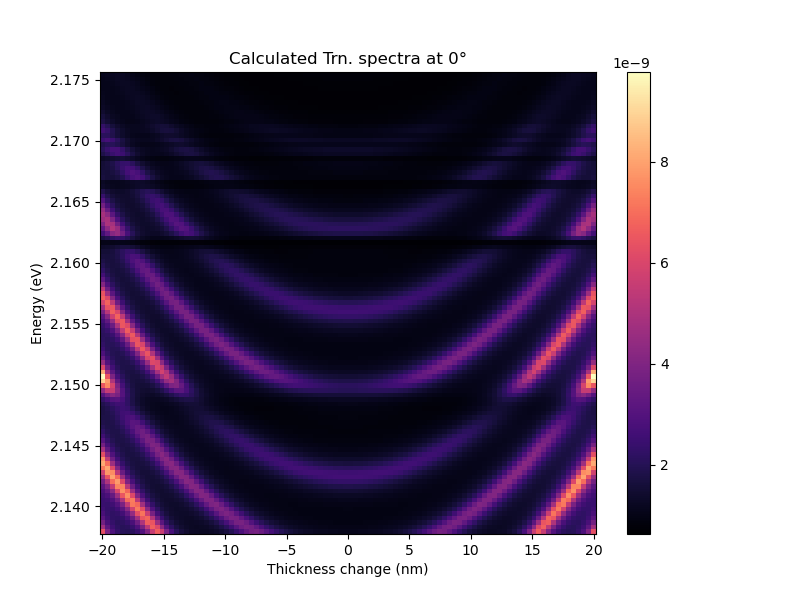

In [49]:
from datetime import datetime
import os

# datetime object containing current date and time
now = datetime.now()
 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y--%H-%M-%S")

dataID = dt_string # unique ID
newDir = "Data/TMM/"+dt_string
os.makedirs(newDir)

# Saving data
np.savetxt(newDir+'/TRefldata.dat', rdata, delimiter='\t')
np.savetxt(newDir+'/Transmdata.dat', tdata, delimiter='\t')
np.savetxt(newDir+'/Reflddata.dat', rddata, delimiter='\t')
np.savetxt(newDir+'/Transmddata.dat', tddata, delimiter='\t')
np.savetxt(newDir+'/thicknessaxis.dat', dact, delimiter='\t')

# plotting data
import matplotlib.pyplot as plt

tdata_trans = tdata[:]
tdata_trans = (tdata_trans)

fig, ax = plt.subplots(figsize=(8,6))

# Plotting figures
ax.pcolormesh(theta_axis, [1240/x for x in lambda_axis], tdata_trans, cmap='magma')
ax.set_title('Calculated Trn. spectra at varying angle')
ax.set_xlabel('Angle $(^o)$')
ax.set_ylabel('Energy (eV)')

tddata_trans = tddata[:]
tddata_trans = np.flipud(tddata_trans)
#tddata_trans = np.fliplr(tddata_trans)

plt.pcolormesh(([x-dact[round(len(dact)/2)] for x in dact]), ([1240/x for x in lambda_axis]), (tddata_trans), cmap='magma')  # Transpose tddata here
plt.title('Calculated Trn. spectra at 0°')
plt.xlabel('Thickness change (nm)')
plt.ylabel('Energy (eV)')
plt.colorbar()
plt.show()


In [51]:
lambdamin = 570 
lambdamax = 580 
lambdastep = 0.05 
lambda_axis = np.linspace(lambdamin, lambdamax, 100) 
dmin = 95.9*300 # these were zero but cannot be 
# 
dmax = 96.1*300 
dact = np.linspace(dmin, dmax, 300)

eV = 1240 / lambda_axis

thetamin = 0
thetamax = 0
thetastep = 1
theta_axis = np.linspace(thetamin, thetamax, 1)

n = len(lambda_axis)
noofangles = len(theta_axis)


n0 = np.ones_like(lambda_axis)

# Load refractive index data
nL_data = np.loadtxt('Data/TMM/SiO2_rfrindxinfo1.dat')
nL1 = np.interp(lambda_axis, nL_data[:, 0] * 1000, nL_data[:, 1])

nH_data = np.loadtxt('Data/TMM/Ta2O5_rfrindxinfo1.dat')
nH2 = np.interp(lambda_axis, nH_data[:, 0] * 1000, nH_data[:, 1])

ActLayer_data = (np.loadtxt('Data/TMM/Cu2O_nkvsnm_1.dat'))


nc = 3 + 1 * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                      ActLayer_data[:, 1]) - 1j * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                                                             np.flip(ActLayer_data[:, 2]))

nH4 = nH2
nL5 = nL1
ns = nL1

N_above = 16
N_below = 16


def DBR(n0, aL, aH, mid, bL, bH, N_above, N_below):
    out = []
    if len(n0) != 0:
        out = [n0]
    
    for i in range(N_above):
        out.append(aL)
        out.append(aH)
    #out.pop(len(out)-1) # Sai's change
    out.append(mid)
    out.append(bH)
    for i in range(N_below):
        out.append(bL)
        out.append(bH)
    if len(n0) != 0:
        out.append(n0)
        
    return out

ri = np.vstack(DBR(n0, nL1, nH2, nc, nL5, nH4, N_above, N_below), dtype = complex)
#ri = np.vstack([n0, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nc, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, n0], dtype = complex)

dL1 = 98.9
dH2 = 67.6
dH4 = dH2
dL5 = dL1
ds = 0

lambda_axis = np.flip(lambda_axis)

rdata = np.zeros((len(lambda_axis), len(theta_axis)))
tdata = np.zeros((len(lambda_axis), len(theta_axis)))
rddata = np.zeros((len(lambda_axis), len(dact)))
tddata = np.zeros((len(lambda_axis), len(dact)))
print(len(dact))
for l in range(1,2):
    for k, dk in enumerate(dact):
        d = np.array(DBR([], dL1, dH2, l*dk, dL1, dH2, N_above, N_below))
        #d = np.array([dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, l*dk, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2])
        #d = np.insert(d, 18, l * dk)
        #print(np.shape(d))
        
        
        
        for i, theta_inp in tqdm(enumerate(theta_axis)):
            clear_output(wait=True) 
            r_0N = np.zeros(n, dtype = complex)
            t_0N = np.zeros(n, dtype = complex)
            for j in range(n):
                r_0N[j], t_0N[j] = cavtrnTM6(theta_inp, ri[:, j], d, lambda_axis[j])
            R_0N = np.abs(r_0N) ** 2
            T_0N = np.abs(t_0N) ** 2
            rdata[:, i] = R_0N
            tdata[:, i] = T_0N
        rddata[:, k] = rdata[:, 0]
        tddata[:, k] = tdata[:, 0]




1it [00:00,  6.54it/s]


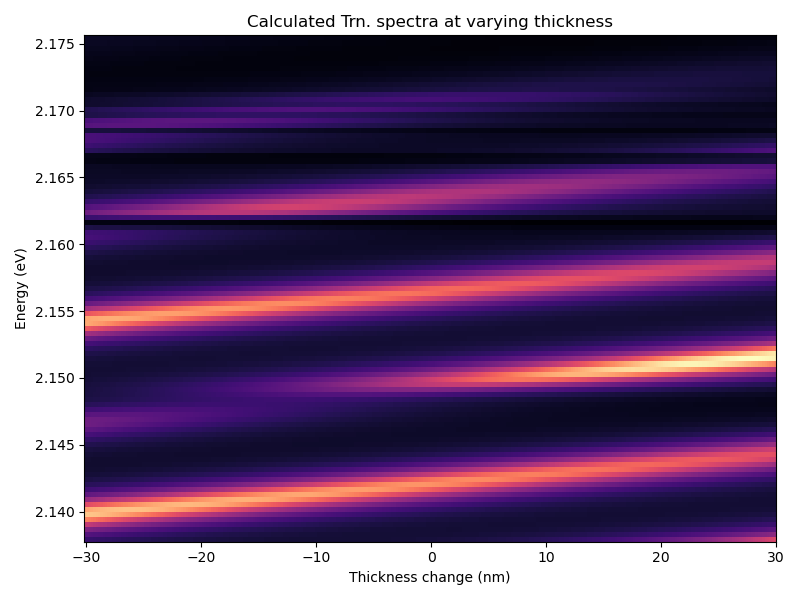

In [52]:
tddata_trans = tddata[:]
tddata_trans = np.fliplr(tddata_trans)

fig, ax = plt.subplots(figsize=(8,6))
ax.pcolormesh(([x-dact[round(len(dact)/2)] for x in dact]), ([1240/x for x in lambda_axis]), (tddata_trans), cmap='magma')  # Transpose tddata here
ax.set_title('Calculated Trn. spectra at varying thickness')
ax.set_xlabel('Thickness change (nm)')
ax.set_ylabel('Energy (eV)')
plt.tight_layout()


### Variable cavity linewidth

Determining the linewidth (full width half maximum) of an empty cavity at various energies.

Linewidth occurs from incorporating experimental data regarding the absorption of Cu2O at various energies.

200


200it [03:35,  1.08s/it]


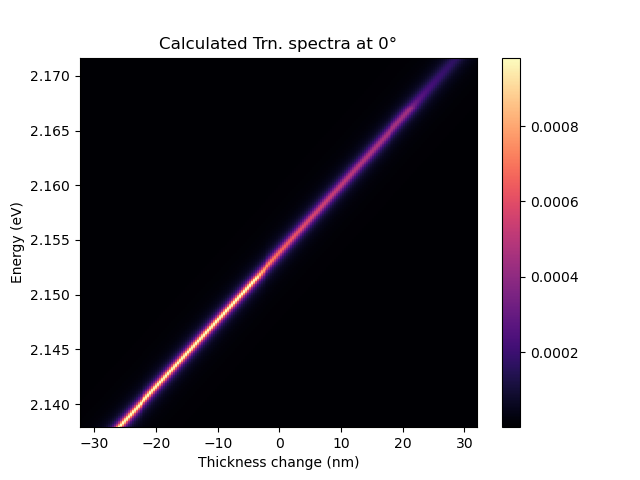

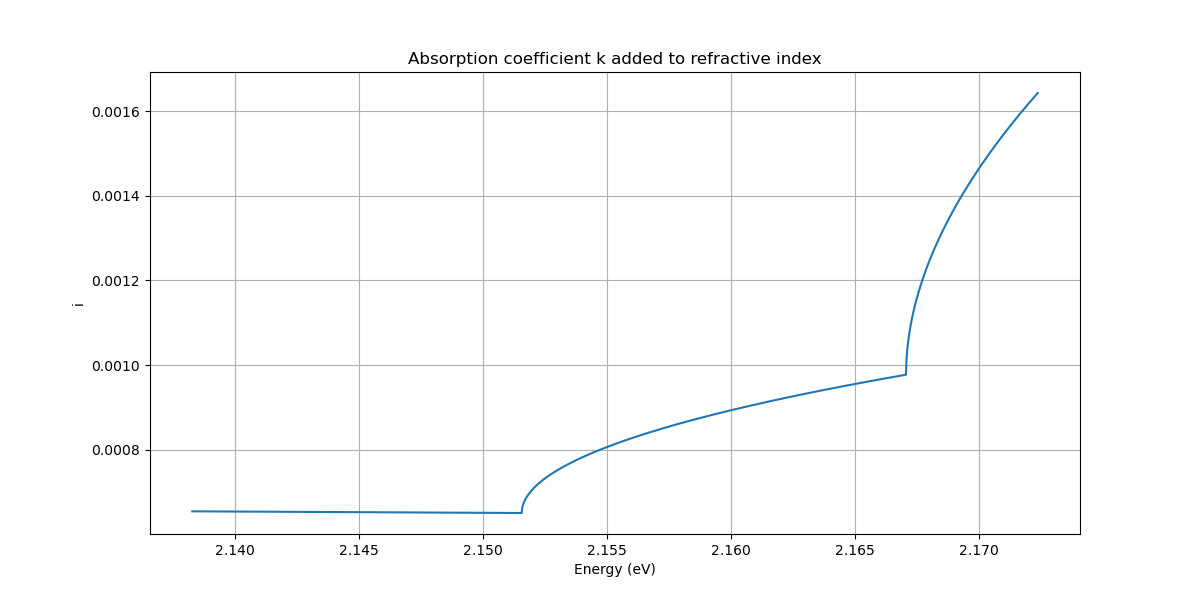

In [108]:
%matplotlib widget
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from IPython.display import clear_output
from numpy.linalg import eigh
from numpy.linalg import eig
from tqdm import tqdm
# trnasmission through an interface

def intrftrn(thetari, ni, nj):
    thetarj = np.arcsin((ni) * np.sin(thetari) / (nj))  # using Snell's law for the next medium
    
    # for TE polarization or s polarized or E-field prep. to plane of incidence
    r_ij = ((ni * np.cos(thetari) - nj * np.cos(thetarj)) / (ni * np.cos(thetari) + nj * np.cos(thetarj)))
    t_ij = (2 * ni * np.cos(thetari) / (nj * np.cos(thetarj) + ni * np.cos(thetari)))
    
    T_ij = 1 / t_ij * np.array([[1, r_ij], [r_ij, 1]], dtype="complex")  # Transfer matrix
    
    return thetarj, T_ij

# transmission through a medium
def medtrn(thetarj, nj, d_j, lambda_0):
    phi_j = 2 * np.pi * nj * d_j * np.cos(thetarj) / lambda_0  # calculating phase difference
    
    T_j = np.array([[np.exp(1j * phi_j), 0], [0, np.exp(-1j * phi_j)]], dtype="complex")  # Transfer matrix
    
    return T_j

def cavtrnTE6(theta0, ri, d, lambda_0):
    numinterf = d.shape[0]  # number of thicknesses of intermediate layers
    nummed = ri.shape[0]  # number of layers

    thetar0 = np.deg2rad(theta0)  # angle in radians

    T_p = np.eye(2, dtype="complex")  # first transfer matrix

    for p in range(numinterf):
        thetar1, T_01 = intrftrn(thetar0, ri[p], ri[p + 1])  # transmission from air to first interface
        T_1 = medtrn(thetar1, ri[p + 1], d[p], lambda_0)  # Transmission through medium 1
        thetar0 = thetar1
        T_p =  T_p@T_01@T_1

    thetar1, T_exitint = intrftrn(thetar0, ri[numinterf], ri[numinterf + 1])  # transmission from air to first interface
    T_p = T_p@T_exitint

    T_0N = T_p  # final transfer matrix
    r_0N = T_0N[1, 0] / T_0N[0, 0]  # reflection coeff
    t_0N = 1 / T_0N[0, 0]  # transmisson coeff

    return r_0N, t_0N

def cavtrnTM6(theta0, ri, d, lambda_0):
    numinterf = len(d)  # number of thicknesses of intermediate layers
    nummed = len(ri)  # number of layers

    thetar0 = np.deg2rad(theta0)  # angle in radians

    T_p = np.eye(2, dtype="complex")  # first transfer matrix

    for p in range(numinterf):
        thetar1, T_01 = intrftrn(thetar0, ri[p], ri[p + 1])  # transmission from air to first interface
        T_1 = medtrn(thetar1, ri[p + 1], d[p], lambda_0)  # Transmission through medium 1
        thetar0 = thetar1
        T_p = T_p@T_01@T_1

    thetar1, T_exitint = intrftrn(thetar0, ri[numinterf], ri[numinterf + 1])  # transmission from air to first interface
    T_p = T_p@T_exitint

    T_0N = T_p  # final transfer matrix
    r_0N = T_0N[1, 0] / T_0N[0, 0]  # reflection coeff
    t_0N = 1 / T_0N[0, 0]  # transmisson coeff

    return r_0N, t_0N

def intrftrn(thetari, ni, nj):
    thetarj = np.arcsin((ni) * np.sin(thetari) / (nj))  # using Snell's law for the next medium
    
    # for TM polarization or p polarized or E-field parallel to plane of incidence
    r_ij = ((nj * np.cos(thetari) - ni * np.cos(thetarj)) / (nj * np.cos(thetari) + ni * np.cos(thetarj)))
    t_ij = (2 * ni * np.cos(thetari) / (nj * np.cos(thetari) + ni * np.cos(thetarj)))

    T_ij = 1 / t_ij * np.array([[1, r_ij], [r_ij, 1]], dtype="complex")  # Transfer matrix
    
    return thetarj, T_ij

def medtrn(thetarj, nj, d_j, lambda_0):
    phi_j = 2 * np.pi * nj * d_j * np.cos(thetarj) / lambda_0  # calculating phase difference
    
    T_j = np.array([[np.exp(1j * phi_j), 0], [0, np.exp(-1j * phi_j)]], dtype="complex")  # Transfer matrix
    
    return T_j

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
font_size = 20

# Fetching data
data      = np.loadtxt('Data/AbsCoefficient_Data.txt', delimiter=',')
energy    = data[:, 0]
spectrum  = data[:, 1]
spectrum -= 100  # Correction for Fresnel Coeff.

# Phonon absorption profile [√X]
def Phonon(E, c, h, E_n):
    diff = E-E_n
    diff[diff < 0] = 0
    output = c*np.sqrt(diff)
    return output+h

# Flipping the data so it goes left to right
energyR = np.flip(energy)
spectrumR = np.flip(spectrum)
masterFit2 = [[-0.46330487483511545, -0.30920701922350025, -0.2925033671363471, -0.2514081488459684, -0.2845513802891673, -0.27113096936661274, -0.12423925671820012, 0.2591441567194842, 3.095682194399115, -2.3400977468233943, -0.6320836681926992], [0.30174202779882664, 0.13771930523203024, 0.07392542846660023, 0.03792825975855692, 0.023132006616818676, 0.01581510947186072, 0.013185431199106304, 0.007984890613794218, 0.0004872216502796389, 0.07862637664502475, 0.17676321472668183], [1.0002317490777592, 1.000044685614082, 1.0000141511730893, 1.0000169329511468, 1.0000104525614852, 1.000010975892848, 1.0000045539989417, 0.9999877749837047, 0.9999679288206244, 1.0009271258660963, 0.9977096708203321], [0.0028439586067818532, 0.0007258674467351671, 0.00035990101032045395, 0.0002318134343443412, 0.00019541879377823335, 0.0001800183482638966, 0.00018080089146911595, 0.00017554747897633122, 0.00012920540548853735, 8.765143397530647e-06, 0.0066958951447672185], [0.4953347835319395, 584.5072454116013, 1859.5311402846912], 47.25752071539266]

# Finding peaks
peaks, props = find_peaks(spectrumR, 400)
peaks = peaks[:-1] # Index of each peak


# def Phonon(E, c, h, E_n):
# 3 phonon backgrounds
P1 = Phonon(energyR[:-553], masterFit2[-2][0], masterFit2[-1], 2.115) # 2.115 from experimental data
P2 = Phonon(energyR[:-553], masterFit2[-2][1], masterFit2[-1], energyR[peaks[0]])
P3 = Phonon(energyR[:-553], masterFit2[-2][2], masterFit2[-1], energyR[peaks[2]])
P  = P1 + P2 + P3

fig, ax = plt.subplots(figsize=(12,6))

def a(E):
    # Find index of closest matching value
    index = np.abs(energyR[:-553] - E).argmin()
    return P[index]

def a(E):
    # Find index of closest matching value
    #index = np.abs(energyR[:-553] - E).argmin()
    #return P[index]
    
    E = np.array([E])
    
    
    P1 = Phonon(E, masterFit2[-2][0], masterFit2[-1], 2.115) # 2.115 from experimental data
    P2 = Phonon(E, masterFit2[-2][1], masterFit2[-1], energyR[449])
    P3 = Phonon(E, masterFit2[-2][2], masterFit2[-1], energyR[894])
    P  = P1 + P2 + P3
    return P[0]
    
def absorptionCoeff(E):
    lam = 1239.8 / E
    lamCM = lam*10**-7
    
    return a(E)*lamCM/(4*np.pi)


lambdamin = 570.8
lambdamax = 580
lambdastep = 0.05 
lambda_axis = np.linspace(lambdamin, lambdamax, 5000)
energies = [1240/x for x in lambda_axis[:-50]]
k = []
aVals = []
for E in energies:
    aVals.append(a(E))
    k.append(absorptionCoeff(E))

    
plt.plot(energies, k)
ax.set_title("Absorption coefficient k added to refractive index")
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("i")
ax.grid(True)


lambdamin = 571
lambdamax = 580
lambdastep = 0.05 
lambda_axis = np.linspace(lambdamin, lambdamax, 500)
dmin = 95*32 # these were zero but cannot be 
dmax = 97*32
dact = np.linspace(dmin, dmax, 200)

eV = 1240 / lambda_axis

thetamin = 0
thetamax = 0
thetastep = 1
theta_axis = np.linspace(thetamin, thetamax, 1)

n = len(lambda_axis)
noofangles = len(theta_axis)

n0 = np.ones_like(lambda_axis)

# Load refractive index data
nL_data = np.loadtxt('Data/TMM/SiO2_rfrindxinfo1.dat')
nL1 = np.interp(lambda_axis, nL_data[:, 0] * 1000, nL_data[:, 1])

nH_data = np.loadtxt('Data/TMM/Ta2O5_rfrindxinfo1.dat')
nH2 = np.interp(lambda_axis, nH_data[:, 0] * 1000, nH_data[:, 1])

ActLayer_data = (np.loadtxt('Data/TMM/Cu2O_nkvsnm_1.dat'))


nc = 3 + 1 * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                      ActLayer_data[:, 1]) - 1j * np.interp(np.flip(lambda_axis), np.flip(ActLayer_data[:, 0]), 
                                                             np.flip(ActLayer_data[:, 2]))
nc  = [3+0j for n in nc]
nc0 = nc[:]

energies = [1240/x for x in lambda_axis]
energies = np.flip(energies)


for i in range(len(nc)):
    nc[i] = 3+1j*absorptionCoeff(energies[i])


nH4 = nH2
nL5 = nL1
ns = nL1

N_above = 13
N_below = 10


def DBR(n0, aL, aH, mid, bL, bH, N_above, N_below):
    out = []
    if len(n0) != 0:
        out = [n0]
    
    for i in range(N_above):
        out.append(aL)
        out.append(aH)
    #out.pop(len(out)-1) # Sai's change
    out.append(mid)
    out.append(bH)
    for i in range(N_below):
        out.append(bL)
        out.append(bH)
    if len(n0) != 0:
        out.append(n0)
        
    return out

ri = np.vstack(DBR(n0, nL1, nH2, nc, nL5, nH4, N_above, N_below), dtype = complex)
ri0 =  np.vstack(DBR(n0, nL1, nH2, nc0, nL5, nH4, N_above, N_below), dtype = complex)
#ri = np.vstack([n0, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nL1, nH2, nc, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, nL5, nH4, n0], dtype = complex)

dL1 = 98.9
dH2 = 67.6
dH4 = dH2
dL5 = dL1
ds = 0

lambda_axis = np.flip(lambda_axis)

rdata = np.zeros((len(lambda_axis), len(theta_axis)))
tdata = np.zeros((len(lambda_axis), len(theta_axis)))
rddata = np.zeros((len(lambda_axis), len(dact)))
tddata = np.zeros((len(lambda_axis), len(dact)))

tdata0 = np.zeros((len(lambda_axis), len(theta_axis)))
tddata0 = np.zeros((len(lambda_axis), len(dact)))
print(len(dact))
for l in range(1,2):
    for k, dk in tqdm(enumerate(dact)):
        d = np.array(DBR([], dL1, dH2, l*dk, dL1, dH2, N_above, N_below))
        #d = np.array([dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, l*dk, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2, dL1, dH2])
        #d = np.insert(d, 18, l * dk)
        #print(np.shape(d))
        
        
        
        for i, theta_inp in enumerate(theta_axis):
            #clear_output(wait=True) 
            r_0N = np.zeros(n, dtype = complex)
            t_0N = np.zeros(n, dtype = complex)
            t_0N0 = np.zeros(n, dtype = complex)
            for j in range(n):
                r_0N[j], t_0N[j] = cavtrnTM6(theta_inp, ri[:, j], d, lambda_axis[j])
                _, t_0N0[j] = cavtrnTM6(theta_inp, ri0[:, j], d, lambda_axis[j])
            R_0N = np.abs(r_0N) ** 2
            T_0N = np.abs(t_0N) ** 2
            T_0N0 = np.abs(t_0N0) ** 2

            rdata[:, i] = R_0N
            tdata[:, i] = T_0N
            tdata0[:, i] = T_0N0
        rddata[:, k] = rdata[:, 0]
        tddata[:, k] = tdata[:, 0]
        tddata0[:, k] = tdata0[:, 0]


tddata_trans = tddata[:]
tddata_trans = np.fliplr(tddata_trans)


tddata_trans0 = tddata0[:]
tddata_trans0 = np.fliplr(tddata_trans0)
        

D = dact[:]
L = lambda_axis[:]
    
plt.figure()
plt.pcolormesh(([x-dact[round(len(dact)/2)] for x in dact]), ([1240/x for x in lambda_axis]), (tddata_trans), cmap='magma')  # Transpose tddata here
plt.title('Calculated Trn. spectra at 0°')
plt.xlabel('Thickness change (nm)')
plt.ylabel('Energy (eV)')
plt.colorbar()
plt.show()


### Plotting cross sections of TMM calculations, finding their FWHM, and curve fitting this to a multiple of the imaginary component of the refractive index of Cu2O

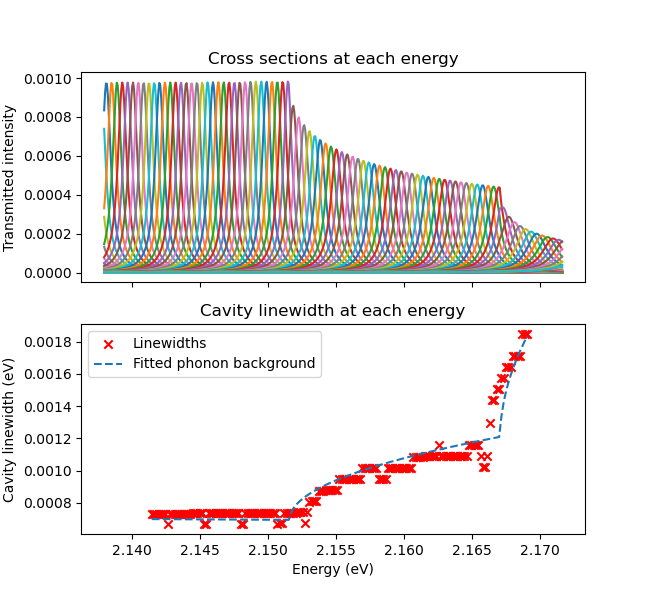

In [110]:
lambdamin = 571
lambdamax = 580
lambdastep = 0.05 
lambda_axis = np.linspace(lambdamin, lambdamax, 5000)
Energies = [1240/x for x in lambda_axis]

# Calculate FWHM for each value in Energies
fwhm_values = []

Energies = np.flip(Energies)

def getFWHM(x,y):
    peak, _ = find_peaks(y)
    peak = peak[0] if len(peak) != 0 else 0
    peak_y = y[peak]
    peak_half = peak_y/2.0
    
    start = 0
    stop  = 0

    for i in range(len(y)-peak):
        plus = y[peak+i]
        if plus <= peak_half:
            stop = peak+i
            break
            
    for i in range(peak):
        minus = y[peak-i]
        if minus <= peak_half:
            start = peak-i
            break
    
    return np.abs(stop-start)*np.abs(x[1]-x[0])


for i,energy in enumerate(dact):
    
    # Extract spectrum at the corresponding index
    spectrum  = tddata_trans[i, :]
        
    fwhm_values.append(getFWHM(energies, spectrum))

def getFWHM(energies, spectrum):
    half_max = np.max(spectrum) / 2
    peak_indices = np.where(spectrum >= half_max)[0]
    if len(peak_indices) < 2:
        return np.nan  # Cannot compute FWHM if there are less than 2 points above half-maximum

    left_index = peak_indices[0]
    right_index = peak_indices[-1]

    left_energy = energies[left_index]
    right_energy = energies[right_index]

    fwhm = right_energy - left_energy
    return fwhm

values = []
fig, ax = plt.subplots(2,1, figsize=(6.5,6), sharex = True)
for i in range(len(tddata_trans[1,:])):
    spectrum = tddata_trans[:,i]
    if i % 2 == 0:
        ax[0].plot(energies, spectrum)
    values.append(getFWHM(energies, spectrum))
    
    
lambdamin = 571
lambdamax = 580
lambdastep = 0.05 
lambda_axis = np.linspace(lambdamin, lambdamax, 200)
Energies = [1240/x for x in lambda_axis]
xData = np.flip(Energies)[21:-15]


ax[1].scatter(xData, values[21:-15], color="red", marker="x", label="Linewidths")

yData=[]
for x in xData:
    yData.append(absorptionCoeff(x))


def linear_model(x, m, c):
    a = []
    for val in x:
        a.append(absorptionCoeff(val))
    return [val*m for val in a] + c




popt, _ = curve_fit(linear_model, xData, values[21:-15])
fit_values = linear_model(xData, *popt)

# Plot the fit
ax[0].set_title("Cross sections at each energy")
ax[0].set_ylabel("Transmitted intensity")
ax[1].set_title("Cavity linewidth at each energy")
ax[1].plot(xData, fit_values, label='Fitted phonon background', linestyle='--')
ax[1].set_xlabel("Energy (eV)")
ax[1].set_ylabel("Cavity linewidth (eV)")
ax[1].legend()


### Creating combined plot

[ 1.57641767e+00 -3.31144118e-04]


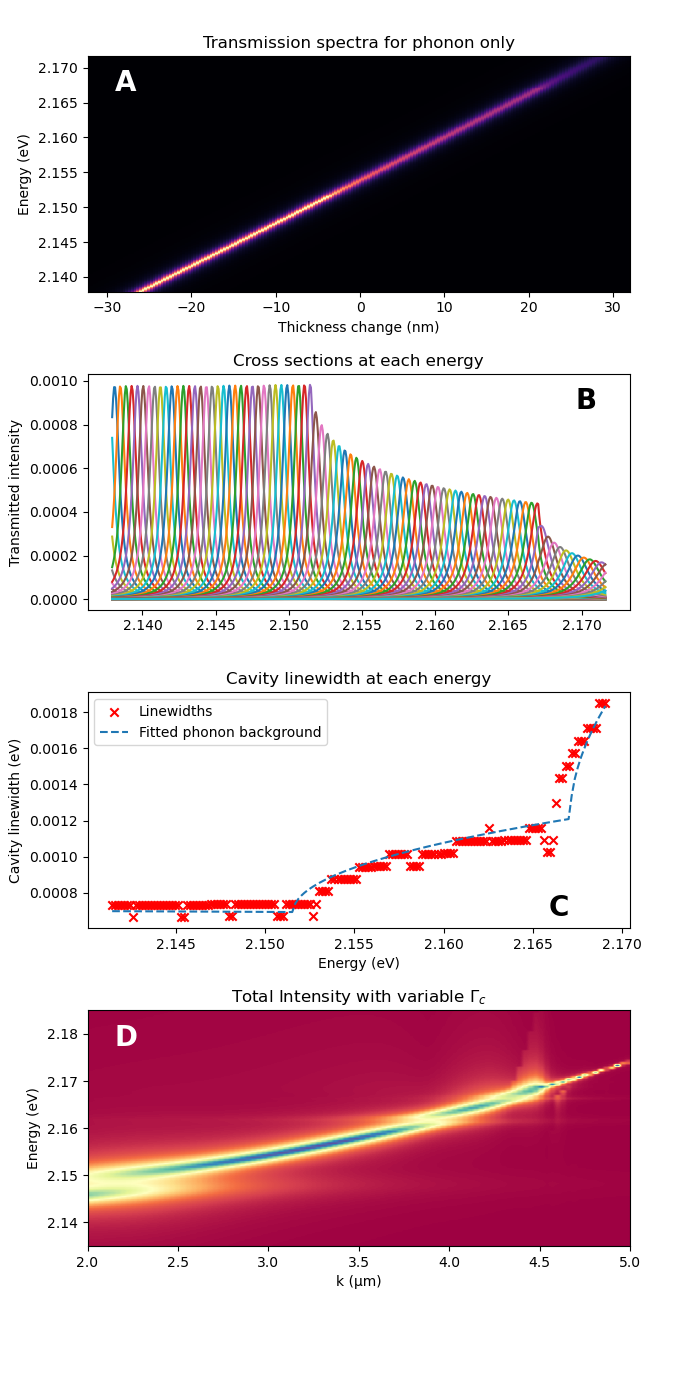

In [111]:
fig, ax = plt.subplots(4,1, figsize=(7,14))
ax = ax.flatten()

ax[0].pcolormesh(([x-dact[round(len(D)/2)] for x in D]), ([1240/x for x in L]), (tddata_trans), cmap='magma')  # Transpose tddata here
ax[0].set_title('Transmission spectra for phonon only')
ax[0].set_xlabel('Thickness change (nm)')
ax[0].set_ylabel('Energy (eV)')
ax[0].annotate('A', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=20, weight='bold', color="white")

values = []
for i in range(len(tddata_trans[1,:])):
    spectrum = tddata_trans[:,i]
    if i % 2 == 0:
        ax[1].plot(energies, spectrum)
    values.append(getFWHM(energies, spectrum))
        
lambdamin = 571
lambdamax = 580
lambdastep = 0.05 
lambda_axis = np.linspace(lambdamin, lambdamax, 200)
Energies = [1240/x for x in lambda_axis]
xData = np.flip(Energies)[21:-15]

ax[2].scatter(xData, values[21:-15], color="red", marker="x", label="Linewidths")

yData=[]
for x in xData:
    yData.append(absorptionCoeff(x))


def linear_model(x, m, c):
    a = []
    for val in x:
        a.append(absorptionCoeff(val))
    return [val*m for val in a] + c

popt, _ = curve_fit(linear_model, xData, values[21:-15])
fit_values = linear_model(xData, *popt)

# Plot the fit
ax[1].set_title("Cross sections at each energy")
ax[1].set_ylabel("Transmitted intensity")
ax[1].annotate('B', xy=(0.9, 0.85), xycoords='axes fraction', fontsize=20, weight='bold', color="black")
ax[2].set_title("Cavity linewidth at each energy")
ax[2].plot(xData, fit_values, label='Fitted phonon background', linestyle='--')
ax[2].set_xlabel("Energy (eV)")
ax[2].set_ylabel("Cavity linewidth (eV)")
ax[2].legend()
ax[2].annotate('C', xy=(0.85, 0.05), xycoords='axes fraction', fontsize=20, weight='bold', color="black")

ax[3].imshow(total_intensity2, extent=[kParam[0], kParam[1], EParam[0], EParam[1]], aspect='auto', origin='lower', cmap='Spectral')
ax[3].set_xlabel('k (μm)')
ax[3].set_ylabel('Energy (eV)')
ax[3].set_title('Total Intensity with variable $Γ_c$')
ax[3].annotate('D', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=20, weight='bold', color="white")
plt.subplots_adjust(wspace=0.2, hspace=0.35, top=0.96)    

print(popt)
